In [186]:
import tarfile
tar_path = 'data/'
cup_video_path = 'Vid_B_cup'
extract_to = 'data'

with tarfile.open(tar_path+cup_video_path+'.tar.xz') as f:
    f.extractall(extract_to)

In [194]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
plt.rcParams["axes.grid"] = False # grid off

# Video Generation with HeatMap

In [188]:
from tqdm import tqdm
import torch
import cv2
import time
import seaborn as sns

def get_heatmaps(model, centroids, frames, image_shape, frames_step=1, num_classes=2, use_gpu=True):
    since = time.time()
    model.eval()
    if use_gpu:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        model = model.to(device)
    heat_maps = []
    frames_cpy = frames.copy()
    with torch.set_grad_enabled(False):
        for idx in tqdm(range(0, len(frames), frames_step), desc="Generate Heat Maps"):
            frames_cpy[idx] = np.moveaxis(frames_cpy[idx], -1, 0)
            frames_cpy[idx] = torch.tensor(frames_cpy[idx])
            frames_cpy[idx] = frames_cpy[idx].float()
            frames_cpy[idx] = frames_cpy[idx].unsqueeze(0)
            if use_gpu:
                frames_cpy[idx] = frames_cpy[idx].to(device)
            embeddings = model(frames_cpy[idx])
            if use_gpu:
                embeddings = embeddings.data.cpu().numpy()
            else:
                embeddings = embeddings.data.numpy()
            heat_map = get_heat_map(embeddings, image_shape, centroids, num_classes)
            heat_maps.append(heat_map)
    time_elapsed = time.time() - since
    print('Time Elapsed (get_heatmaps func) {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return heat_maps

def get_real_heatmaps(model, centroids, frames, image_shape, frames_step=1, num_classes=2, use_gpu=True):
    since = time.time()
    model.eval()
    if use_gpu:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        model = model.to(device)
    heat_maps = []
    frames_cpy = frames.copy()
    with torch.set_grad_enabled(False):
        for idx in tqdm(range(0, len(frames), frames_step), desc="Generate Heat Maps"):
            frames_cpy[idx] = np.moveaxis(frames_cpy[idx], -1, 0)
            frames_cpy[idx] = torch.tensor(frames_cpy[idx])
            frames_cpy[idx] = frames_cpy[idx].float()
            frames_cpy[idx] = frames_cpy[idx].unsqueeze(0)
            if use_gpu:
                frames_cpy[idx] = frames_cpy[idx].to(device)
            embeddings = model(frames_cpy[idx])
            if use_gpu:
                embeddings = embeddings.data.cpu().numpy()
            else:
                embeddings = embeddings.data.numpy()
            heat_map = get_real_heatmap(embeddings, image_shape, centroids, cmap='jet')
            heat_maps.append(heat_map)
    time_elapsed = time.time() - since
    print('Time Elapsed (get_heatmaps func) {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return heat_maps
    
def create_video(heat_maps, video_path, width, height, froucc=0, fps=1):
    since = time.time()
    video = cv2.VideoWriter(video_path, froucc, fps, (width, height), 0)
    for heat_map in heat_maps:
        video.write((heat_map*255).astype('uint8'))
    video.release()
    time_elapsed = time.time() - since
    print('Time Elapsed (create_video func) {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


def easy_create_video(model, centroids, frames, video_path, width, height, froucc=0, use_gpu=True, fps=1, frames_step=1, num_classes=2, ret_heat_maps=False, real_heat_map=False):
    since = time.time()
    if real_heat_map:
        heat_maps = get_real_heatmaps(model, centroids, frames, (height, width), frames_step, num_classes, use_gpu)
    else:   
        heat_maps = get_heatmaps(model, centroids, frames, (height, width), frames_step, num_classes, use_gpu)
    create_video(heat_maps, video_path, width, height, froucc, fps)
    time_elapsed = time.time() - since
    print('Time Elapsed (easy_create_video func) {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    if heat_maps: return heat_maps

(150, 150, 3)
frames count: 629


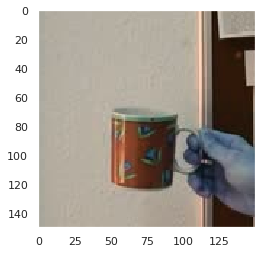

In [193]:
import os

image_folder = tar_path+cup_video_path
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images = sorted(images)
start_point = (100, 50)   
end_point = (200, 150)
padding = 25
start_point_pad = (start_point[0]-padding, start_point[1]-padding)
end_point_pad = (end_point[0]+padding, end_point[1]+padding)
frames_cropped = []
for image in images:
    frame = cv2.imread(os.path.join(image_folder, image))
    frame = frame[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
    frames_cropped.append(frame)
height_cropped, width_cropped, layers = frames_cropped[0].shape

print(frames_cropped[0].shape)
print("frames count:", len(frames_cropped))

plt.grid = False
plt.imshow(frames_cropped[0])
plt.show()

(240, 320, 3)
frames count: 629


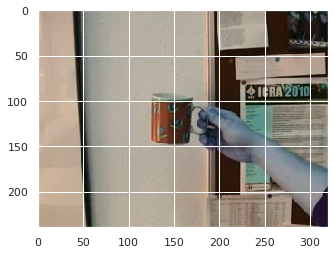

In [147]:
import os

image_folder = tar_path+cup_video_path
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images = sorted(images)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
print(frame.shape)
frames = []
for image in images:
    frames.append(cv2.imread(os.path.join(image_folder, image)))
print("frames count:", len(frames))

plt.imshow(frames[0])
plt.show()

## Centroids and HeatMap Functions

In [148]:
import pickle
def save_centroids(path):
    with open(path,'wb') as f:
        pickle.dump(centroids, f)
def load_centroids(path):
    centroids = None
    with open(path,'rb') as f:
        centroids = pickle.load(f)
    return centroids

def get_heat_map(embeddings, shape, centriods, num_classes=2):
    heat_map = np.zeros(len(embeddings))
    for emb_idx, embedding in enumerate(embeddings):
        min_dist = np.inf
        for class_idx, centriod in enumerate(centriods):
            dist = np.linalg.norm(centriod - embedding)
            if(dist < min_dist):
                min_dist = dist
                heat_map[emb_idx] = class_idx
    heat_map = heat_map.reshape(shape)
    return heat_map

def get_real_heatmap(embeddings, shape, centriods, cmap='jet'):
    heat_map = np.zeros(len(embeddings))
    for emb_idx, embedding in enumerate(embeddings):
        dist_background = np.linalg.norm(embedding - centriods[0])
        dist_foreground = np.linalg.norm(embedding - centriods[1])
        heat_map[emb_idx] = float(dist_background) / dist_foreground
    heat_map = heat_map.reshape(shape)
    return heat_map

## Load image

(240, 320)


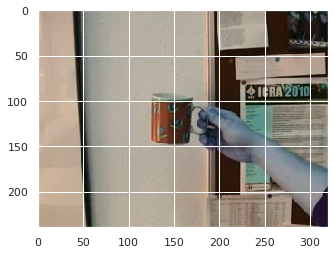

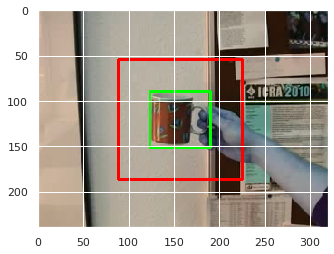

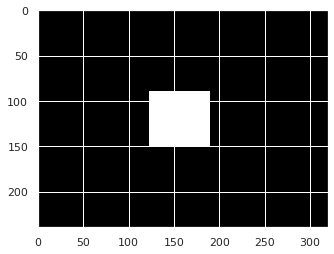

In [149]:
img_path = tar_path+cup_video_path+'/img0002.jpg'

#Import image
orig_image = cv2.imread(img_path)
#Show the image with matplotlib
start_point = (123, 90)   
end_point = (190, 152)
padding = 35
start_point_pad = (start_point[0]-padding, start_point[1]-padding)
end_point_pad = (end_point[0]+padding, end_point[1]+padding)
# Blue color in BGR 
color = (0, 255, 0) 
color_pad = (255, 0, 0)
# Line thickness of 2 px 
thickness = 2
image = orig_image.copy()
image = cv2.rectangle(image, start_point, end_point, color, thickness) 
image = cv2.rectangle(image, start_point_pad, end_point_pad, color_pad, thickness) 


# label image
image_labels = np.zeros((orig_image.shape[0], orig_image.shape[1]))
image_labels[start_point[1]:end_point[1], start_point[0]:end_point[0]] = 1.0
print(image_labels.shape)
#Show the image with matplotlib
plt.imshow(orig_image)
plt.show()
plt.imshow(image)
plt.show()
plt.imshow(image_labels, cmap=plt.cm.gray)
plt.show()

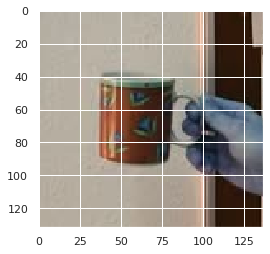

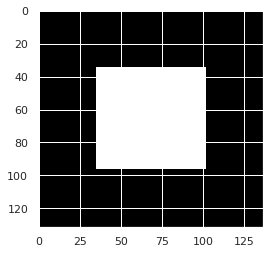

torch.Size([132, 137])
torch.Size([1, 3, 132, 137])
torch.Size([18084])


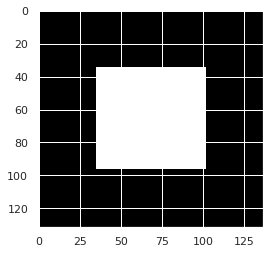

tensor([ 4830,  4831,  4832,  ..., 13251, 13252, 13253])
tensor([    0,     1,     2,  ..., 18081, 18082, 18083])


In [150]:
import torch

img = orig_image[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(img)
plt.show()

labels = image_labels[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(labels, cmap=plt.cm.gray)
plt.show()

img = np.moveaxis(img, -1, 0)
img = torch.tensor(img)
img = img.float()
img = img.unsqueeze(0)
labels = torch.tensor(labels)

print(labels.shape)
print(img.shape)
flatten_labels = labels.view(-1)
print(flatten_labels.shape)

test_flatten_labels = flatten_labels.reshape((labels.shape[0], labels.shape[1]))

plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

foreground = torch.where(flatten_labels == 1)[0]
background = torch.where(flatten_labels == 0)[0]
print(foreground)
print(background)

In [151]:
import random

def get_pixels_triplets(outputs, labels, batch_size, foreground, background):
    anchors = []
    postives = []
    negatives = []
#     print("len(background):", len(background))
#     print("len(foreground):", len(foreground))
#     print("len(outputs):", len(outputs))
    
    for _ in range(batch_size):
        anchor_label = random.randint(0, 1)
        if anchor_label == 0:
            # choose index from foreground and background
            anchor_idx = random.randrange(0, len(background))
            pos_idx = random.randrange(0, len(background))
            while anchor_idx == pos_idx:
                pos_idx = random.randrange(0, len(background))
            neg_idx = random.randrange(0, len(foreground))
            
            # get real index from outputs 
            anchor_idx = background[anchor_idx]
            pos_idx = background[pos_idx]
            neg_idx = foreground[neg_idx]
            
        elif anchor_label == 1:
            # choose index from foreground and background
            anchor_idx = random.randrange(0, len(foreground))
            pos_idx = random.randrange(0, len(foreground))
            while anchor_idx == pos_idx:
                pos_idx = random.randrange(0, len(foreground))
            neg_idx = random.randrange(0, len(background))
            
            # get real index from outputs
            anchor_idx = foreground[anchor_idx]
            pos_idx = foreground[pos_idx]
            neg_idx = background[neg_idx]
            
        anchors.append(outputs[anchor_idx])
        postives.append(outputs[pos_idx])
        negatives.append(outputs[neg_idx])
    return anchors, postives, negatives

In [152]:
import random

def get_triplet(labels, foreground, background):
    anchor_label = random.randint(0, 1)
    if anchor_label == 0:
        # choose index from foreground and background
        anchor_idx = random.randrange(0, len(background))
        pos_idx = random.randrange(0, len(background))
        while anchor_idx == pos_idx:
            pos_idx = random.randrange(0, len(background))
        neg_idx = random.randrange(0, len(foreground))

        # get real index from outputs 
        anchor_idx = background[anchor_idx]
        pos_idx = background[pos_idx]
        neg_idx = foreground[neg_idx]

    elif anchor_label == 1:
        # choose index from foreground and background
        anchor_idx = random.randrange(0, len(foreground))
        pos_idx = random.randrange(0, len(foreground))
        while anchor_idx == pos_idx:
            pos_idx = random.randrange(0, len(foreground))
        neg_idx = random.randrange(0, len(background))

        # get real index from outputs
        anchor_idx = foreground[anchor_idx]
        pos_idx = foreground[pos_idx]
        neg_idx = background[neg_idx]
    return anchor_idx, pos_idx, neg_idx

In [153]:
import time
from tqdm import tqdm
import copy

def train_model(model, criterion, image, labels, optimizer, foreground, background, num_epochs=25, batch_size=16, num_batches=1, get_min_loss=True):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model.to(device)
    image = image.to(device)
    model.train()
    min_run_loss = np.inf
    best_model_wts = None
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        running_loss = []
        for _ in range(batch_size*num_batches):
            optimizer.zero_grad()
            outputs = model(image)
            anchor_idx, pos_idx, neg_idx = get_triplet(labels, foreground, background)
            loss = criterion(outputs, anchor_idx, pos_idx, neg_idx)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())
        mean_run_loss = np.mean(running_loss)
        print('loss: {:4f}'.format(mean_run_loss))
        if min_run_loss > mean_run_loss:
            min_run_loss = mean_run_loss
            if get_min_loss:
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val loss: {:4f}'.format(min_run_loss))
    
    if get_min_loss:
        model.load_state_dict(best_model_wts)
    return model

def get_centroids(embeddings, foreground, background):
    centroid_background = embeddings[background].sum(0, keepdims=True) / len(background)
    centroid_foreground = embeddings[foreground].sum(0, keepdims=True) / len(foreground)
    return [centroid_background, centroid_foreground]

def embeddings_accuracy(embeddings, targets, shape, centriods, num_classes=2):
    correct = 0
    wrong = 0
    heat_map = np.zeros(len(embeddings))
    for i in range(num_classes):
        inds = np.where(targets==i)[0]
        for emb_idx, point in enumerate(embeddings[inds]):
            min_dist = np.inf
            min_dist_class = -1
            for class_idx, c in enumerate(centriods):
                dist = np.linalg.norm(c-point)
                if(dist < min_dist):
                    # print("point: ({}, {}) which in class {}, closer to centroid: ({}, {}) which in class {}".format(x, y, i, c[0], c[1], idx))
                    min_dist_class = class_idx
                    min_dist = dist
                    heat_map[inds[emb_idx]] = class_idx
            if(i == min_dist_class):
                correct += 1
            else:
                wrong += 1
    print("correct: {}, wrong: {}, accuracy: {}%".format(correct, wrong, (100.0*correct)/(correct + wrong)))
    heat_map = heat_map.reshape(shape)
    return heat_map

In [154]:
import random as rd
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_PCA(embeddings, targets, out_features_size, classes, flat_first=False, is_3D=False,colors=None, pca_title='My PCA Graph', xlim=None, ylim=None, draw_PCA_per_varc=False, figure_size=(10,10), top_range_loadingfactors=None):
    # Generate random colors for each class
    if colors == None:
        colors = []
        r = lambda: rd.randint(0, 200) # (0, 255) not 255 to avoid colors diff than white
        for _ in range(len(classes)):
            colors.append('#%02X%02X%02X' % (r(),r(),r()))
    assert(len(colors) == len(classes))

    # First center and scale the data
    # After centering avg value for each gene will be 0
    # After scaling std for each gene will be 1
    embeddings_indecies = ['embedding' + str(i) for i in range(1, len(embeddings[0])+1)]
    df = pd.DataFrame(columns=embeddings_indecies, index=np.arange(1, len(embeddings)+1))
    for i in range(out_features_size):
        df.loc[:, embeddings_indecies[i]] = embeddings[:, i]
    # print(df.head())
    # print("Shape:", df.shape)
                          
    # scaled_data = preprocessing.scale(df.T) if(samples_are_columns) else preprocessing.scale(df)
    scaled_data = preprocessing.scale(df)
    pca = PCA()
    pca.fit(scaled_data) # calc loading scores for every pca
    pca_data = pca.transform(scaled_data) # generate coordinates    
    per_var = np.round(pca.explained_variance_ratio_*100, decimals=1) # Percentage of Explained Variance in %
    # labels to PCA number corresponding to Percentage of Explained Variance
    labels = ['PC' + str(i) for i in range(1, len(per_var)+1)] 
    
    # plot scree plot of loading factors 
    if draw_PCA_per_varc:
        plt.figure(figsize=figure_size)
        plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
        plt.ylabel('Percentage of Explained Variance')
        plt.xlabel('Principal Component')
        plt.title('Scree Plot')
        plt.show()
    
    #the following code makes a fancy looking plot using PC1 and PC2
    pca_df = pd.DataFrame(pca_data, index=np.arange(1, len(embeddings)+1), columns=labels)
    # print(pca_df)
    if is_3D:
        ax = plt.figure(figsize=figure_size)
        ax = Axes3D(ax)
    else:
        plt.figure(figsize=figure_size)
    for i in range(len(classes)):
        inds = np.where(targets == i)[0]
        if is_3D:
            ax.scatter(pca_df.iloc[inds, 0], pca_df.iloc[inds, 1], pca_df.iloc[inds, 2], alpha=0.5, color=colors[i])
        else:
            plt.scatter(pca_df.iloc[inds, 0], pca_df.iloc[inds, 1], alpha=0.5, color=colors[i])
    if is_3D:
        if xlim:
            ax.xlim(xlim[0], xlim[1])
        if ylim:
            ax.ylim(ylim[0], ylim[1])

        ax.set_title(pca_title)
        ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
        ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
        ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))
        ax.legend(classes, loc=(1.04, 0))
    else:
        if xlim:
            plt.xlim(xlim[0], xlim[1])
        if ylim:
            plt.ylim(ylim[0], ylim[1])

        plt.title(pca_title)
        plt.xlabel('PC1 - {0}%'.format(per_var[0]))
        plt.ylabel('PC2 - {0}%'.format(per_var[1]))
        plt.legend(classes, loc=(1.04, 0))

        
    #########################
    #
    # Determine which genes had the biggest influence on PC1
    #
    #########################

    ## get the name of the top 10 measurements (genes) that contribute
    ## most to pc1.
    ## first, get the loading scores
    if top_range_loadingfactors != None:
        loading_scores = pd.Series(pca.components_[0], index=embeddings_indecies)
        ## now sort the loading scores based on their magnitude
        sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

        # get the names of the top 10 genes
        top_loading_factors = sorted_loading_scores[top_range_loadingfactors[0]: top_range_loadingfactors[1]].index.values

        ## print the gene names and their scores (and +/- sign)
        print(loading_scores[top_loading_factors])


In [155]:
import torch.nn as nn
import torch.nn.functional as F

class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum()
    
    
    def forward(self, outputs, anchor_idx, pos_idx, neg_idx, size_average=True):
        anchor = outputs[anchor_idx].unsqueeze(0)
        pos = outputs[pos_idx].unsqueeze(0)
        neg = outputs[neg_idx].unsqueeze(0)

        distance_positive = nn.functional.pairwise_distance(anchor, pos)
        distance_negative = nn.functional.pairwise_distance(anchor, neg)
#         print("distance_positive:", distance_positive)
#         print("distance_negative:", distance_negative)
        
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

class EmbeddingNet(nn.Module):
    def __init__(self, last_out_channel=8):
        super(EmbeddingNet, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x


class EmbeddingNet2(nn.Module):
    def __init__(self, last_out_channel=32):
        super(EmbeddingNet2, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
#         print("x.shape:", x.shape)
#         x = x.view(-1, self.last_out_channel)
#         print("x.shape:", x.shape)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x
    
class EmbeddingNet3(nn.Module):
    def __init__(self, last_out_channel=64):
        super(EmbeddingNet3, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=32, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x
    
class EmbeddingNet4(nn.Module):
    def __init__(self, last_out_channel=256):
        super(EmbeddingNet4, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=128, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x

class EmbeddingNet5(nn.Module):
    def __init__(self, last_out_channel=256):
        super(EmbeddingNet5, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=128, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=self.last_out_channel, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x


class EmbeddingNet6(nn.Module):
    def __init__(self, last_out_channel=256):
        super(EmbeddingNet6, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=128, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(self.last_out_channel),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x

class EmbeddingNet7(nn.Module):
    def __init__(self, last_out_channel=8):
        super(EmbeddingNet7, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(4),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=4, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(self.last_out_channel),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x
    
class EmbeddingNet8(nn.Module):
    def __init__(self, last_out_channel=256):
        super(EmbeddingNet8, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(8),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(16),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(32),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=128, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(self.last_out_channel),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x
    
class EmbeddingNet9(nn.Module):
    def __init__(self, last_out_channel=64):
        super(EmbeddingNet9, self).__init__()
        self.last_out_channel = last_out_channel
        self.convnet = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(16),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(in_channels=64, out_channels=self.last_out_channel, kernel_size=(3, 3), stride=1, padding=1),
                                     nn.BatchNorm2d(self.last_out_channel),
                                     nn.ReLU())
    def forward(self, x):
        x = self.convnet(x)
        x = torch.transpose(x, 0, 2)
        x = torch.transpose(x, 1, 3)
        x = x.reshape(-1, self.last_out_channel) 
        return x   

def init_weights(m):
    if isinstance(m, nn.Conv2d):
#         torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.normal_(m.weight, mean=0, std=1.0)

## Experiment 1.1

In [21]:
import torch.optim as optim
last_out_channel = 8
model = EmbeddingNet7(8)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 10000.
criterion = TripletLoss(margin)
n_epochs = 20

In [22]:
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95)

Epochs:   5%|▌         | 1/20 [00:45<14:31, 45.85s/it]

loss: 9990.116211


Epochs:  10%|█         | 2/20 [01:31<13:43, 45.75s/it]

loss: 9979.723633


Epochs:  15%|█▌        | 3/20 [02:16<12:54, 45.57s/it]

loss: 9959.960938


Epochs:  20%|██        | 4/20 [03:02<12:10, 45.63s/it]

loss: 9939.265625


Epochs:  25%|██▌       | 5/20 [03:47<11:23, 45.54s/it]

loss: 9918.097656


Epochs:  30%|███       | 6/20 [04:33<10:37, 45.56s/it]

loss: 9896.884766


Epochs:  35%|███▌      | 7/20 [05:18<09:52, 45.58s/it]

loss: 9877.700195


Epochs:  40%|████      | 8/20 [06:04<09:06, 45.56s/it]

loss: 9857.272461


Epochs:  45%|████▌     | 9/20 [06:50<08:21, 45.61s/it]

loss: 9834.327148


Epochs:  50%|█████     | 10/20 [07:35<07:35, 45.56s/it]

loss: 9812.520508


Epochs:  55%|█████▌    | 11/20 [08:21<06:51, 45.67s/it]

loss: 9789.764648


Epochs:  60%|██████    | 12/20 [09:07<06:05, 45.73s/it]

loss: 9769.683594


Epochs:  65%|██████▌   | 13/20 [09:52<05:19, 45.66s/it]

loss: 9744.334961


Epochs:  70%|███████   | 14/20 [10:38<04:34, 45.76s/it]

loss: 9723.612305


Epochs:  75%|███████▌  | 15/20 [11:24<03:48, 45.71s/it]

loss: 9705.857422


Epochs:  80%|████████  | 16/20 [12:10<03:02, 45.69s/it]

loss: 9680.787109


Epochs:  85%|████████▌ | 17/20 [12:55<02:17, 45.67s/it]

loss: 9656.574219


Epochs:  90%|█████████ | 18/20 [13:41<01:31, 45.68s/it]

loss: 9631.841797


Epochs:  95%|█████████▌| 19/20 [14:26<00:45, 45.43s/it]

loss: 9611.832031


Epochs: 100%|██████████| 20/20 [15:10<00:00, 45.54s/it]

loss: 9589.957031
Best val loss: 9589.957031


In [23]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (10450, 8)
flatten_labels.shape: torch.Size([10450])
zeros count: 0
not zeros count: 10450


correct: 10073, wrong: 377, accuracy: 96.39234449760765%


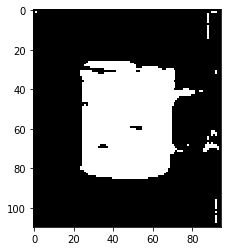

tensor([  1,   1,   1,  ..., 105, 106, 107])
tensor([2400, 2401, 2402,  ..., 8047, 8048, 8049])


In [24]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [27]:
torch.save(model.state_dict(), 'Models/cup_model7_1.pt')

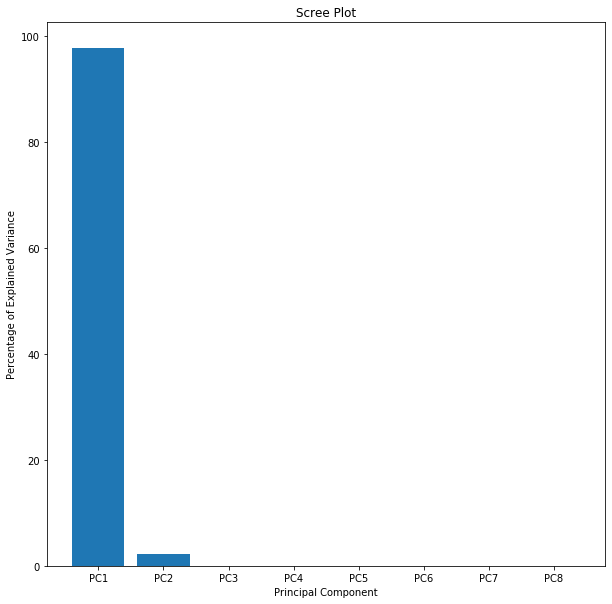

embedding8    0.356306
embedding2    0.356279
embedding3    0.356274
dtype: float64


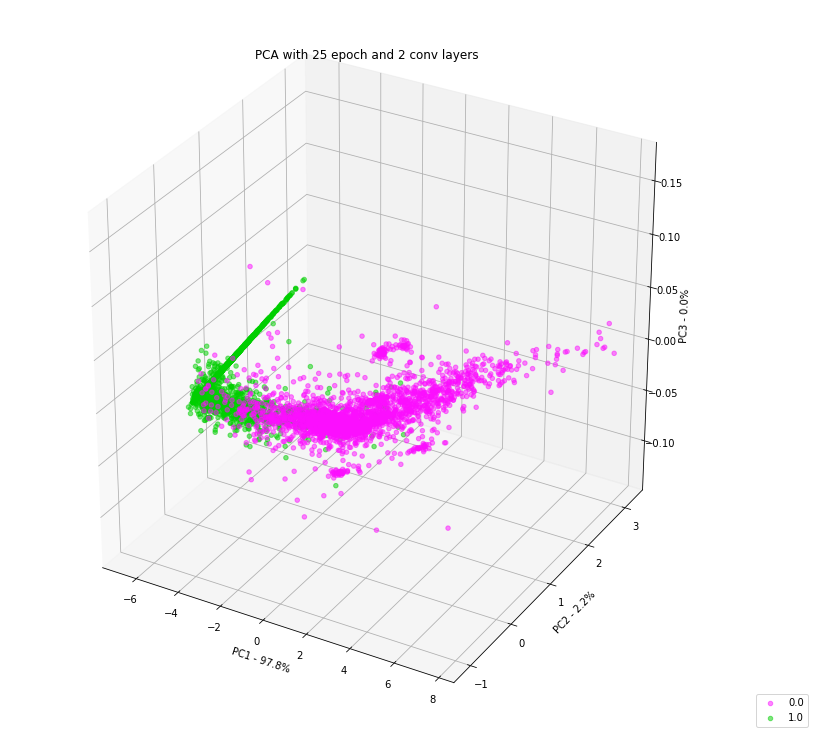

In [26]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

## Experiment 1.2

In [30]:
import torch.optim as optim
last_out_channel = 8
model = EmbeddingNet7(8)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = (10000./256)*last_out_channel
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 20

margin: 312.5


In [31]:
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95)

Epochs:   5%|▌         | 1/20 [00:45<14:18, 45.17s/it]

loss: 301.427429


Epochs:  10%|█         | 2/20 [01:30<13:35, 45.33s/it]

loss: 280.532288


Epochs:  15%|█▌        | 3/20 [02:15<12:49, 45.25s/it]

loss: 258.604950


Epochs:  20%|██        | 4/20 [03:00<12:02, 45.17s/it]

loss: 232.894592


Epochs:  25%|██▌       | 5/20 [03:46<11:18, 45.22s/it]

loss: 209.346909


Epochs:  30%|███       | 6/20 [04:31<10:33, 45.27s/it]

loss: 184.112930


Epochs:  35%|███▌      | 7/20 [05:16<09:47, 45.22s/it]

loss: 160.100876


Epochs:  40%|████      | 8/20 [06:01<08:59, 44.97s/it]

loss: 138.264709


Epochs:  45%|████▌     | 9/20 [06:45<08:14, 44.91s/it]

loss: 116.253265


Epochs:  50%|█████     | 10/20 [07:29<07:26, 44.65s/it]

loss: 101.485069


Epochs:  55%|█████▌    | 11/20 [08:14<06:41, 44.58s/it]

loss: 94.259956


Epochs:  60%|██████    | 12/20 [08:59<05:59, 44.88s/it]

loss: 86.578171


Epochs:  65%|██████▌   | 13/20 [09:44<05:13, 44.84s/it]

loss: 82.827873


Epochs:  70%|███████   | 14/20 [10:29<04:29, 44.88s/it]

loss: 78.968750


Epochs:  75%|███████▌  | 15/20 [11:15<03:45, 45.07s/it]

loss: 78.171181


Epochs:  80%|████████  | 16/20 [12:00<03:00, 45.13s/it]

loss: 75.436333


Epochs:  85%|████████▌ | 17/20 [12:46<02:15, 45.29s/it]

loss: 74.261024


Epochs:  90%|█████████ | 18/20 [13:31<01:30, 45.37s/it]

loss: 73.158012


Epochs:  95%|█████████▌| 19/20 [14:17<00:45, 45.37s/it]

loss: 70.080276


Epochs: 100%|██████████| 20/20 [15:02<00:00, 45.12s/it]

loss: 71.653084
Best val loss: 70.080276


In [38]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (10450, 8)
flatten_labels.shape: torch.Size([10450])
zeros count: 0
not zeros count: 10450


correct: 9315, wrong: 1135, accuracy: 89.13875598086125%


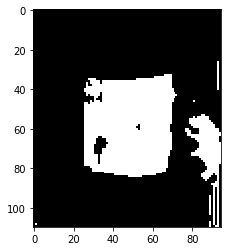

tensor([ 26,  27,  28,  ..., 109, 109, 109])
tensor([2400, 2401, 2402,  ..., 8047, 8048, 8049])


In [39]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [40]:
torch.save(model.state_dict(), 'Models/cup_model7_2.pt')

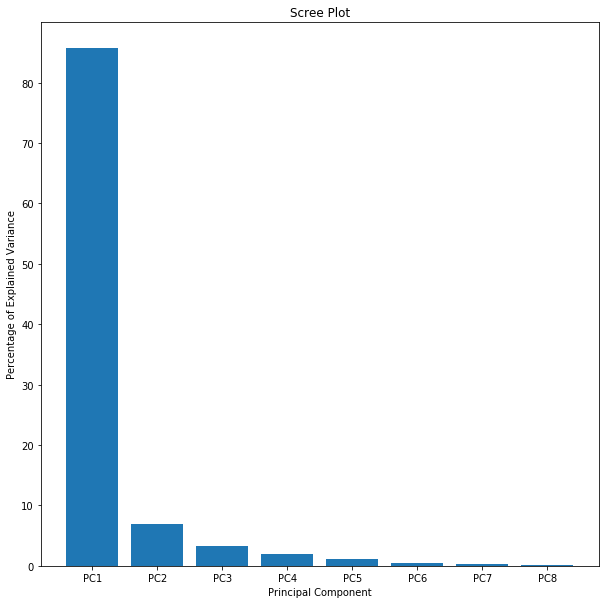

embedding5    0.369890
embedding1    0.369682
embedding6    0.369514
dtype: float64


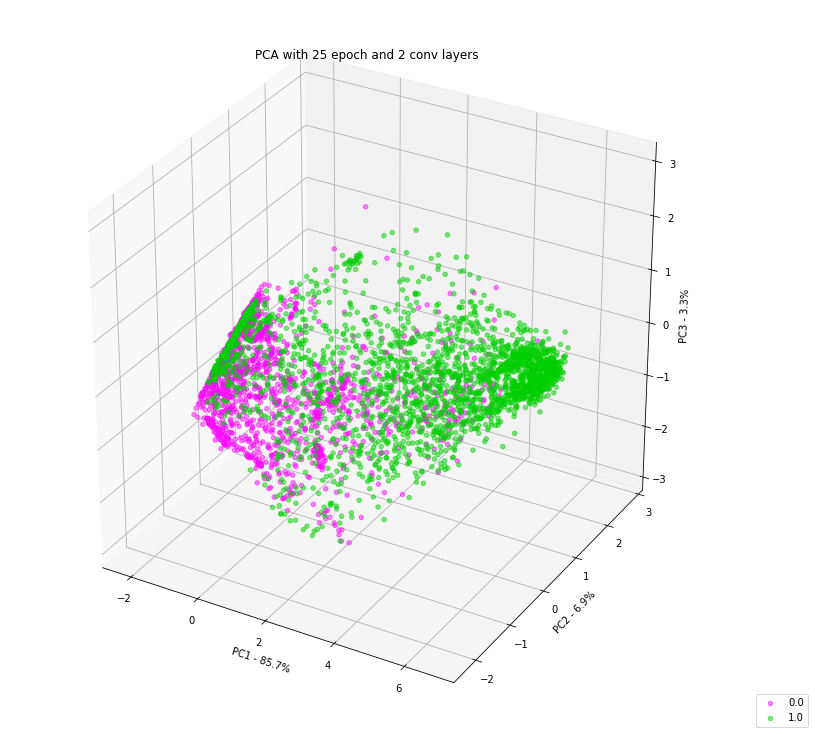

In [41]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

## Experiment 1.3

In [42]:
import torch.optim as optim
import numpy as np

last_out_channel = 8
model = EmbeddingNet7(8)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = (np.sqrt(10000.)/256)*last_out_channel
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 20

margin: 3.125


In [43]:
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95)

Epochs:   5%|▌         | 1/20 [00:45<14:20, 45.30s/it]

loss: 1.231171


Epochs:  10%|█         | 2/20 [01:31<13:38, 45.46s/it]

loss: 0.927269


Epochs:  15%|█▌        | 3/20 [02:17<12:55, 45.62s/it]

loss: 0.845170


Epochs:  20%|██        | 4/20 [03:02<12:06, 45.43s/it]

loss: 0.789383


Epochs:  25%|██▌       | 5/20 [03:47<11:21, 45.41s/it]

loss: 0.803580


Epochs:  30%|███       | 6/20 [04:33<10:37, 45.56s/it]

loss: 0.725880


Epochs:  35%|███▌      | 7/20 [05:18<09:50, 45.41s/it]

loss: 0.729506


Epochs:  40%|████      | 8/20 [06:04<09:06, 45.55s/it]

loss: 0.713139


Epochs:  45%|████▌     | 9/20 [06:50<08:21, 45.63s/it]

loss: 0.663808


Epochs:  60%|██████    | 12/20 [09:07<06:05, 45.68s/it]

loss: 0.630494


Epochs:  65%|██████▌   | 13/20 [09:51<05:17, 45.36s/it]

loss: 0.629921


Epochs:  70%|███████   | 14/20 [10:36<04:30, 45.11s/it]

loss: 0.581654


Epochs:  75%|███████▌  | 15/20 [11:22<03:46, 45.25s/it]

loss: 0.577827


Epochs:  80%|████████  | 16/20 [12:07<03:01, 45.37s/it]

loss: 0.567208


Epochs:  85%|████████▌ | 17/20 [12:53<02:16, 45.36s/it]

loss: 0.555125


Epochs:  90%|█████████ | 18/20 [13:38<01:30, 45.28s/it]

loss: 0.566491


Epochs:  95%|█████████▌| 19/20 [14:23<00:45, 45.41s/it]

loss: 0.571666


Epochs: 100%|██████████| 20/20 [15:09<00:00, 45.48s/it]

loss: 0.548829
Best val loss: 0.548829


In [44]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (10450, 8)
flatten_labels.shape: torch.Size([10450])
zeros count: 0
not zeros count: 10450


correct: 10048, wrong: 402, accuracy: 96.1531100478469%


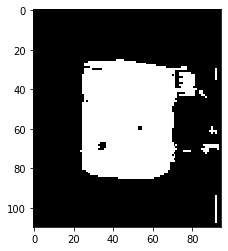

tensor([ 25,  25,  25,  ..., 105, 106, 107])
tensor([2400, 2401, 2402,  ..., 8047, 8048, 8049])


In [45]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [46]:
torch.save(model.state_dict(), 'Models/cup_model7_3.pt')

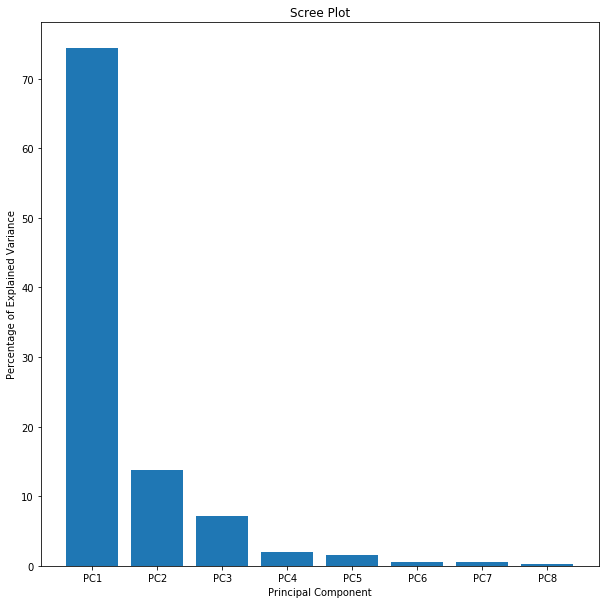

embedding3    0.395652
embedding2    0.387723
embedding4    0.387304
dtype: float64


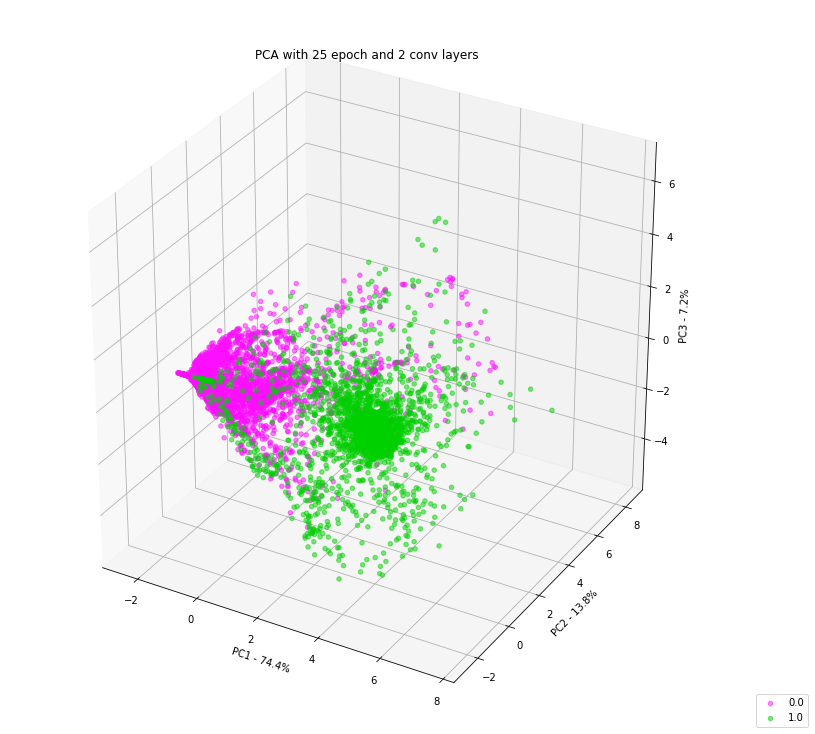

In [47]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

## Continued Experiment 1.1

In [49]:
import torch.optim as optim
import numpy as np

last_out_channel = 8
model = EmbeddingNet7(8)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 10000.
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 10

margin: 10000.0


In [50]:
model.load_state_dict(torch.load('Models/cup_model7_1.pt'))

<All keys matched successfully>

In [51]:
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95)

Epochs:  10%|█         | 1/10 [00:45<06:48, 45.36s/it]

loss: 9566.216797


Epochs:  20%|██        | 2/10 [01:31<06:03, 45.49s/it]

loss: 9543.215820


Epochs:  30%|███       | 3/10 [02:16<05:19, 45.59s/it]

loss: 9519.910156


Epochs:  40%|████      | 4/10 [03:02<04:34, 45.68s/it]

loss: 9497.050781


Epochs:  50%|█████     | 5/10 [03:47<03:47, 45.48s/it]

loss: 9471.782227


Epochs:  60%|██████    | 6/10 [04:33<03:02, 45.62s/it]

loss: 9447.498047


Epochs:  70%|███████   | 7/10 [05:19<02:17, 45.70s/it]

loss: 9429.121094


Epochs:  80%|████████  | 8/10 [06:05<01:31, 45.67s/it]

loss: 9398.374023


Epochs:  90%|█████████ | 9/10 [06:50<00:45, 45.58s/it]

loss: 9379.730469


Epochs: 100%|██████████| 10/10 [07:36<00:00, 45.67s/it]

loss: 9366.747070
Best val loss: 9366.747070


In [52]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (10450, 8)
flatten_labels.shape: torch.Size([10450])
zeros count: 0
not zeros count: 10450


correct: 10051, wrong: 399, accuracy: 96.18181818181819%


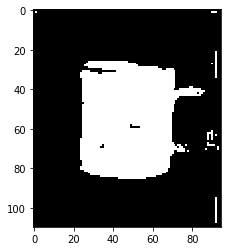

tensor([  1,   1,   1,  ..., 105, 106, 107])
tensor([2400, 2401, 2402,  ..., 8047, 8048, 8049])


In [53]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [54]:
torch.save(model.state_dict(), 'Models/cup_model7_1.pt')

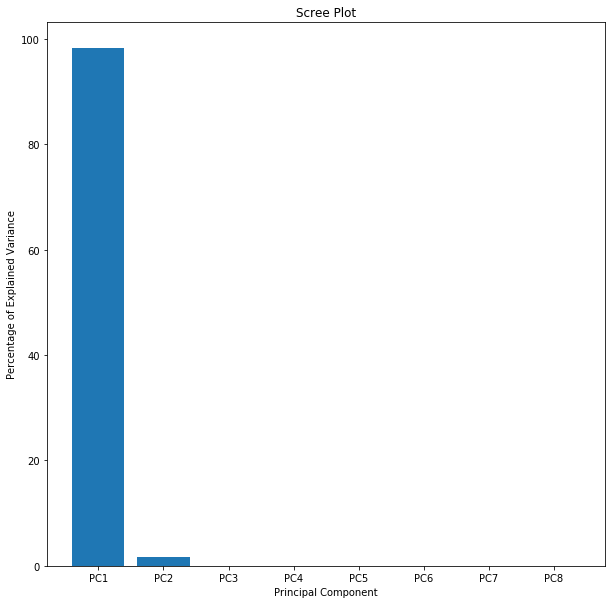

embedding8    0.355748
embedding3    0.355710
embedding4    0.355709
dtype: float64


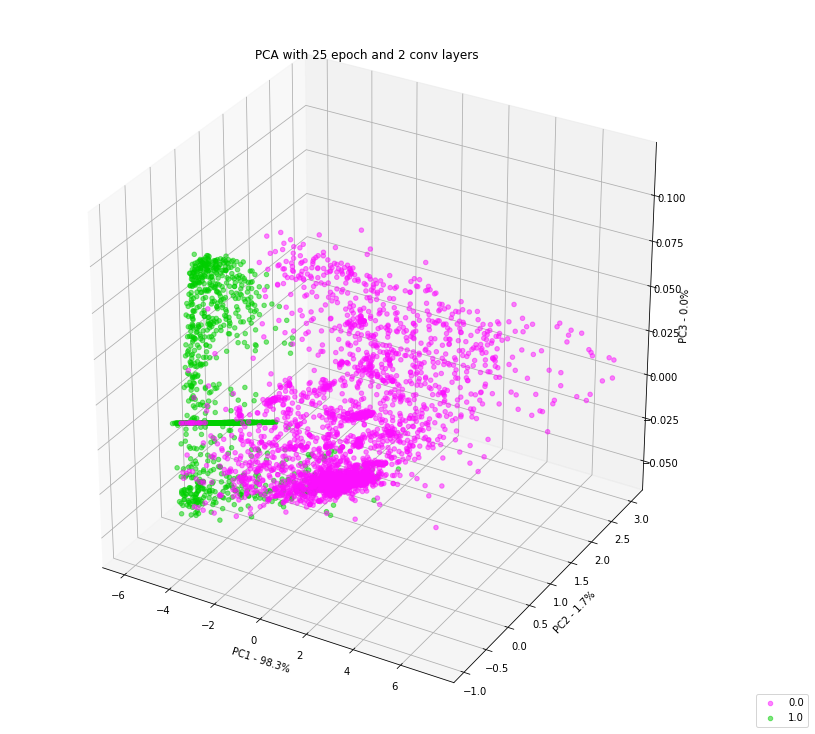

In [55]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [104]:
model_path = 'cup_model7_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [105]:
last_out_channel = 8
model = EmbeddingNet7(last_out_channel)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [106]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (10450, 8)
flatten_labels.shape: torch.Size([10450])
zeros count: 0
not zeros count: 10450


correct: 10051, wrong: 399, accuracy: 96.18181818181819%


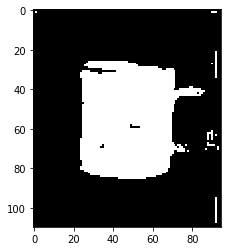

In [107]:
centroids = get_centroids(embeddings, foreground, background)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [108]:
save_centroids(centroid_path)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [109]:
last_out_channel = 8
model = EmbeddingNet7(last_out_channel)

In [110]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/' + model_path + '.pt'))

<All keys matched successfully>

In [98]:
heat_maps = easy_create_video(model, centroids, frames[:300], video_path, width, height, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [04:05<00:00,  2.46s/it]

Time Elapsed (get_heatmaps func) 4m 6s
Time Elapsed (create_video func) 0m 0s
Time Elapsed (easy_create_video func) 4m 6s


In [111]:
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'
heat_maps = easy_create_video(model, centroids, frames_cropped[:300], video_path, width, height, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]

Time Elapsed (get_heatmaps func) 0m 33s
Time Elapsed (create_video func) 0m 0s
Time Elapsed (easy_create_video func) 0m 33s


## Continued Experiment 1.3

In [100]:
model_path = 'cup_model7_3'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_'+model_path+'.avi'

In [68]:
import torch.optim as optim
import numpy as np

last_out_channel = 8
model = EmbeddingNet7(8)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = (np.sqrt(10000.)/256)*last_out_channel
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 10

margin: 3.125


In [69]:
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [70]:
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95)

Epochs:  10%|█         | 1/10 [00:45<06:52, 45.80s/it]

loss: 0.529527


Epochs:  20%|██        | 2/10 [01:32<06:07, 45.95s/it]

loss: 0.525058


Epochs:  30%|███       | 3/10 [02:17<05:20, 45.81s/it]

loss: 0.542246


Epochs:  40%|████      | 4/10 [03:02<04:33, 45.66s/it]

loss: 0.526651


Epochs:  50%|█████     | 5/10 [03:48<03:48, 45.74s/it]

loss: 0.499231


Epochs:  60%|██████    | 6/10 [04:35<03:03, 45.93s/it]

loss: 0.542238


Epochs:  70%|███████   | 7/10 [05:19<02:16, 45.48s/it]

loss: 0.517242


Epochs:  80%|████████  | 8/10 [06:04<01:30, 45.28s/it]

loss: 0.482342


Epochs:  90%|█████████ | 9/10 [06:50<00:45, 45.50s/it]

loss: 0.500721


Epochs: 100%|██████████| 10/10 [07:35<00:00, 45.59s/it]

loss: 0.518970
Best val loss: 0.482342


In [73]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (10450, 8)
flatten_labels.shape: torch.Size([10450])
zeros count: 0
not zeros count: 10450


correct: 10074, wrong: 376, accuracy: 96.40191387559808%


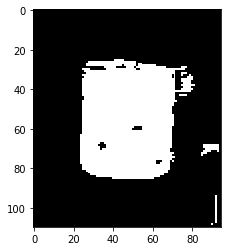

tensor([ 25,  25,  25,  ..., 106, 107, 108])
tensor([2400, 2401, 2402,  ..., 8047, 8048, 8049])


In [74]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [75]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

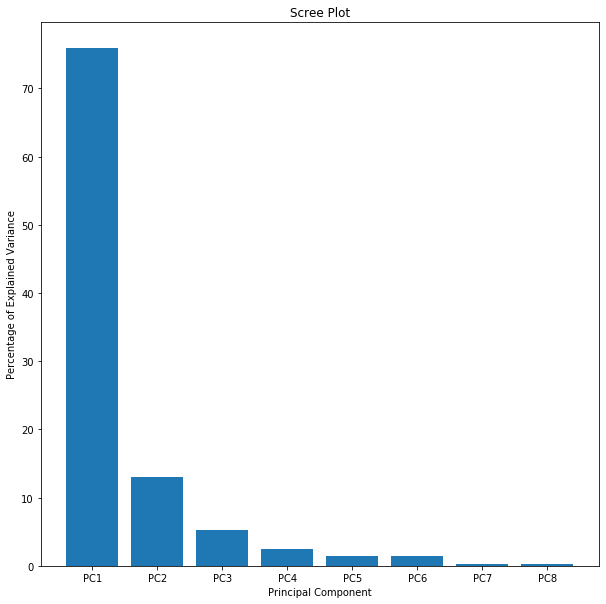

embedding2    0.384875
embedding3    0.382403
embedding6   -0.382193
dtype: float64


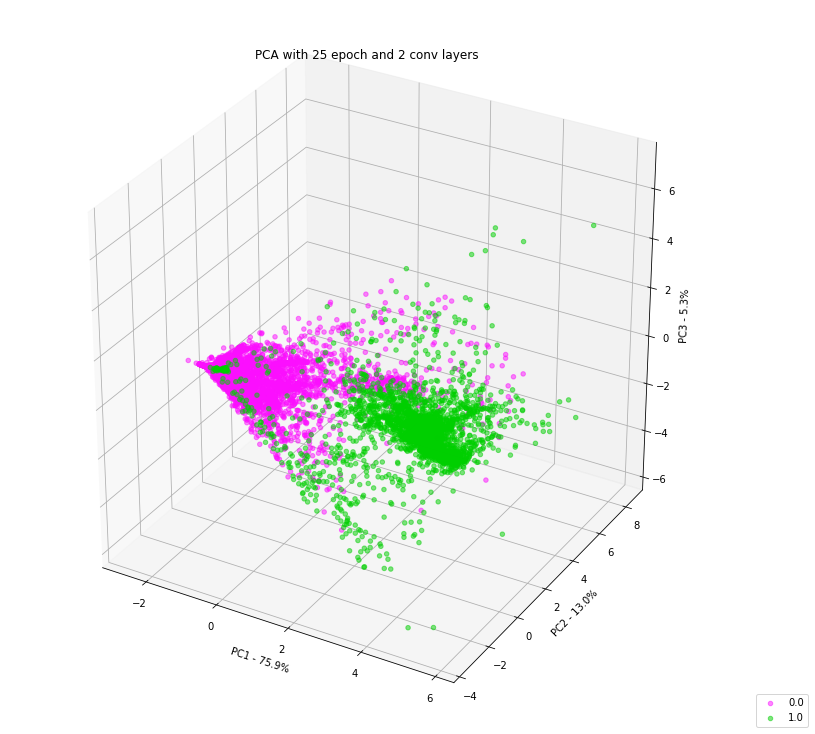

In [76]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [77]:
last_out_channel = 8
model = EmbeddingNet7(last_out_channel)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [78]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (10450, 8)
flatten_labels.shape: torch.Size([10450])
zeros count: 0
not zeros count: 10450


correct: 10074, wrong: 376, accuracy: 96.40191387559808%


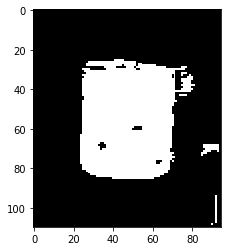

In [79]:
centroids = get_centroids(embeddings, foreground, background)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [80]:
save_centroids(centroid_path)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [101]:
last_out_channel = 8
model = EmbeddingNet7(last_out_channel)

In [102]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/' + model_path + '.pt'))

<All keys matched successfully>

In [94]:
heat_maps = easy_create_video(model, centroids, frames[:300], video_path, width, height, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [04:08<00:00,  2.48s/it]

Time Elapsed (get_heatmaps func) 4m 8s
Time Elapsed (create_video func) 0m 0s
Time Elapsed (easy_create_video func) 4m 8s


In [103]:
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'
heat_maps = easy_create_video(model, centroids, frames_cropped[:300], video_path, width, height, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]

Time Elapsed (get_heatmaps func) 0m 34s
Time Elapsed (create_video func) 0m 0s
Time Elapsed (easy_create_video func) 0m 34s


## Experiment 2.1

In [240]:
model_path = 'cup_model5_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [135]:
import torch.optim as optim
import numpy as np

last_out_channel = 256
model = EmbeddingNet5(last_out_channel)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 10000.
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 25

margin: 10000.0


In [136]:
#model.load_state_dict(torch.load('Models/'+model_path+'.pt'))
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95)

Epochs:   4%|▍         | 1/25 [01:21<32:45, 81.90s/it]

loss: 5247.544434


Epochs:   8%|▊         | 2/25 [02:44<31:27, 82.07s/it]

loss: 2185.084229


Epochs:  12%|█▏        | 3/25 [04:06<30:08, 82.21s/it]

loss: 1203.703003


Epochs:  16%|█▌        | 4/25 [05:29<28:50, 82.42s/it]

loss: 934.677673


Epochs:  20%|██        | 5/25 [06:52<27:28, 82.43s/it]

loss: 827.366943


Epochs:  24%|██▍       | 6/25 [08:14<26:06, 82.45s/it]

loss: 821.388000


Epochs:  28%|██▊       | 7/25 [09:37<24:46, 82.56s/it]

loss: 546.588196


Epochs:  32%|███▏      | 8/25 [11:00<23:24, 82.60s/it]

loss: 484.186646


Epochs:  36%|███▌      | 9/25 [12:23<22:02, 82.67s/it]

loss: 446.392731


Epochs:  40%|████      | 10/25 [13:45<20:37, 82.51s/it]

loss: 440.635162


Epochs:  44%|████▍     | 11/25 [15:06<19:08, 82.00s/it]

loss: 398.165985


Epochs:  48%|████▊     | 12/25 [16:27<17:43, 81.81s/it]

loss: 378.099640


Epochs:  52%|█████▏    | 13/25 [17:48<16:19, 81.59s/it]

loss: 357.505859


Epochs:  56%|█████▌    | 14/25 [19:09<14:55, 81.43s/it]

loss: 374.263062


Epochs:  60%|██████    | 15/25 [20:30<13:33, 81.40s/it]

loss: 282.430450


Epochs:  64%|██████▍   | 16/25 [21:52<12:12, 81.38s/it]

loss: 262.200043


Epochs:  72%|███████▏  | 18/25 [24:35<09:31, 81.58s/it]

loss: 221.144608


Epochs:  76%|███████▌  | 19/25 [25:57<08:10, 81.81s/it]

loss: 226.622528


Epochs:  80%|████████  | 20/25 [27:19<06:49, 81.87s/it]

loss: 289.288971


Epochs:  84%|████████▍ | 21/25 [28:41<05:27, 81.91s/it]

loss: 239.352249


Epochs:  88%|████████▊ | 22/25 [30:03<04:05, 81.94s/it]

loss: 274.939697


Epochs:  92%|█████████▏| 23/25 [31:25<02:43, 81.89s/it]

loss: 220.216599


Epochs:  96%|█████████▌| 24/25 [32:48<01:22, 82.00s/it]

loss: 230.014328


Epochs: 100%|██████████| 25/25 [34:09<00:00, 82.00s/it]

loss: 232.889038
Best val loss: 220.216599


In [137]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

embeddings.shape: (10450, 256)
flatten_labels.shape: torch.Size([10450])


zeros count: 52
not zeros count: 10398
correct: 10439, wrong: 11, accuracy: 99.89473684210526%


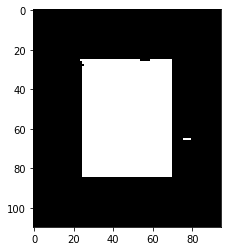

tensor([25, 25, 25,  ..., 84, 84, 84])
tensor([2400, 2401, 2402,  ..., 8047, 8048, 8049])


In [138]:
c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [139]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

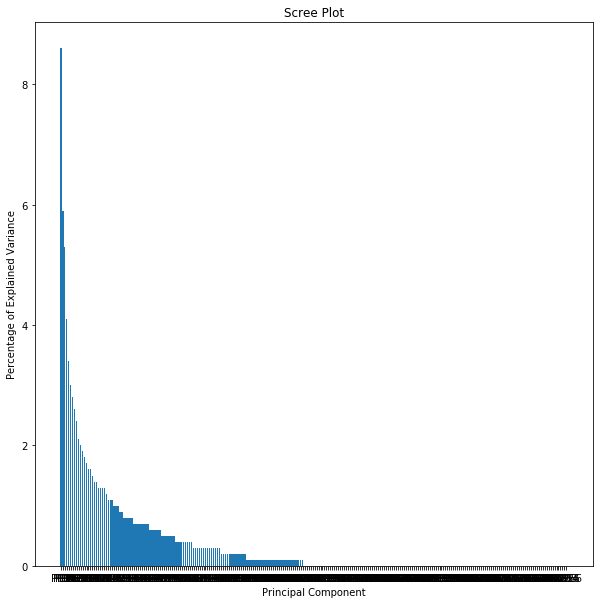

embedding200    0.178982
embedding206    0.175448
embedding125    0.172272
dtype: float64


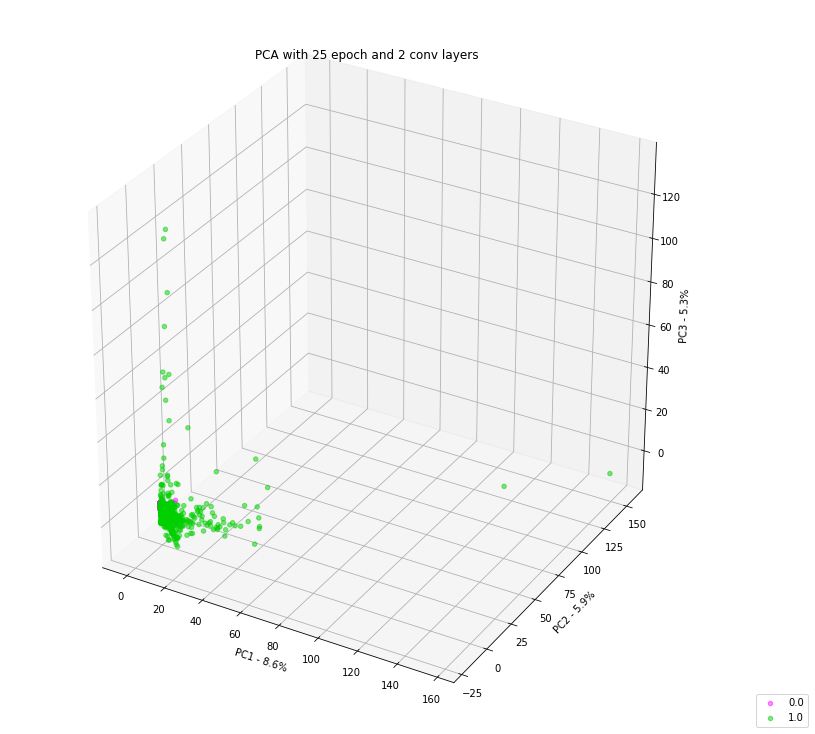

In [140]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [241]:
last_out_channel = 256
model = EmbeddingNet5(last_out_channel)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [242]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (10450, 256)
flatten_labels.shape: torch.Size([10450])
zeros count: 52
not zeros count: 10398


correct: 10439, wrong: 11, accuracy: 99.89473684210526%


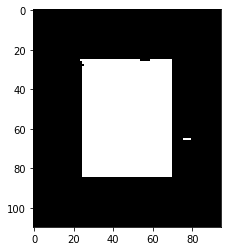

In [243]:
centroids = get_centroids(embeddings, foreground, background)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [244]:
save_centroids(centroid_path)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [250]:
last_out_channel = 256
model = EmbeddingNet5(last_out_channel)

In [251]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [252]:
heat_maps = easy_create_video(model, centroids, frames_cropped[:300], video_path, width_cropped, height_cropped, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it]

Time Elapsed (get_heatmaps func) 2m 17s
Time Elapsed (create_video func) 0m 0s
Time Elapsed (easy_create_video func) 2m 17s


(240, 320)


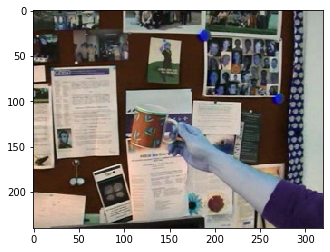

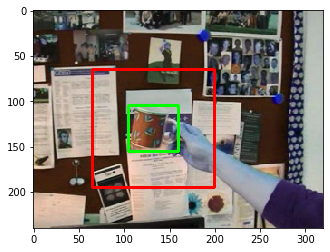

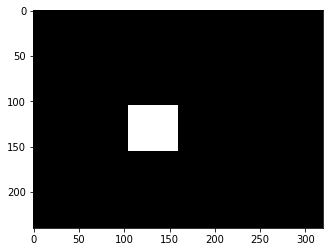

In [427]:
img_path = tar_path+cup_video_path+'/img0149.jpg'

#Import image
orig_image = cv2.imread(img_path)
#Show the image with matplotlib
start_point = (105, 105)   
end_point = (160, 155)
padding = 40
start_point_pad = (start_point[0]-padding, start_point[1]-padding)
end_point_pad = (end_point[0]+padding, end_point[1]+padding)
# Blue color in BGR 
color = (0, 255, 0) 
color_pad = (255, 0, 0)
# Line thickness of 2 px 
thickness = 2
image = orig_image.copy()
image = cv2.rectangle(image, start_point, end_point, color, thickness) 
image = cv2.rectangle(image, start_point_pad, end_point_pad, color_pad, thickness) 


# label image
image_labels = np.zeros((orig_image.shape[0], orig_image.shape[1]))
image_labels[start_point[1]:end_point[1], start_point[0]:end_point[0]] = 1.0
print(image_labels.shape)
#Show the image with matplotlib
plt.imshow(orig_image)
plt.show()
plt.imshow(image)
plt.show()
plt.imshow(image_labels, cmap=plt.cm.gray)
plt.show()

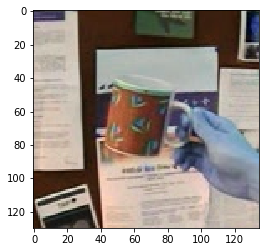

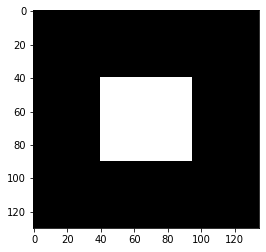

torch.Size([130, 135])
torch.Size([1, 3, 130, 135])
torch.Size([17550])


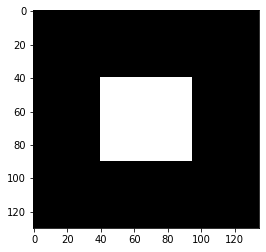

tensor([ 5440,  5441,  5442,  ..., 12107, 12108, 12109])
tensor([    0,     1,     2,  ..., 17547, 17548, 17549])


In [428]:
import torch

img = orig_image[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(img)
plt.show()

labels = image_labels[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(labels, cmap=plt.cm.gray)
plt.show()

img = np.moveaxis(img, -1, 0)
img = torch.tensor(img)
img = img.float()
img = img.unsqueeze(0)
labels = torch.tensor(labels)

print(labels.shape)
print(img.shape)
flatten_labels = labels.view(-1)
print(flatten_labels.shape)

test_flatten_labels = flatten_labels.reshape((labels.shape[0], labels.shape[1]))

plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

foreground = torch.where(flatten_labels == 1)[0]
background = torch.where(flatten_labels == 0)[0]
print(foreground)
print(background)

## Experiment 3

In [292]:
model_path = 'cup_model6_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [293]:
import torch.optim as optim
import numpy as np

last_out_channel = 256
model = EmbeddingNet6(last_out_channel)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 10000.
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 25

margin: 10000.0


In [294]:
#model.load_state_dict(torch.load('Models/'+model_path+'.pt'))
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95)

Epochs:   4%|▍         | 1/25 [01:26<34:39, 86.65s/it]

loss: 9975.618164


Epochs:   8%|▊         | 2/25 [02:51<33:00, 86.09s/it]

loss: 9850.573242


Epochs:  12%|█▏        | 3/25 [04:16<31:25, 85.68s/it]

loss: 9680.500000


Epochs:  16%|█▌        | 4/25 [05:41<29:57, 85.58s/it]

loss: 9491.743164


Epochs:  20%|██        | 5/25 [07:06<28:26, 85.33s/it]

loss: 9301.334961


Epochs:  24%|██▍       | 6/25 [08:31<27:00, 85.27s/it]

loss: 9100.024414


Epochs:  28%|██▊       | 7/25 [09:56<25:31, 85.08s/it]

loss: 8901.104492


Epochs:  32%|███▏      | 8/25 [11:20<24:03, 84.94s/it]

loss: 8694.108398


Epochs:  36%|███▌      | 9/25 [12:46<22:41, 85.08s/it]

loss: 8496.615234


Epochs:  40%|████      | 10/25 [14:12<21:21, 85.46s/it]

loss: 8283.489258


Epochs:  44%|████▍     | 11/25 [15:37<19:56, 85.43s/it]

loss: 8071.175781


Epochs:  48%|████▊     | 12/25 [17:03<18:32, 85.61s/it]

loss: 7851.349609


Epochs:  52%|█████▏    | 13/25 [18:30<17:10, 85.86s/it]

loss: 7647.186035


Epochs:  56%|█████▌    | 14/25 [19:56<15:46, 86.03s/it]

loss: 7429.956543


Epochs:  60%|██████    | 15/25 [21:23<14:21, 86.17s/it]

loss: 7226.499512


Epochs:  64%|██████▍   | 16/25 [22:49<12:55, 86.14s/it]

loss: 7030.897461


Epochs:  68%|██████▊   | 17/25 [24:15<11:29, 86.24s/it]

loss: 6782.481445


Epochs:  72%|███████▏  | 18/25 [25:41<10:03, 86.23s/it]

loss: 6593.237305


Epochs:  76%|███████▌  | 19/25 [27:08<08:37, 86.20s/it]

loss: 6344.191895


Epochs:  80%|████████  | 20/25 [28:34<07:11, 86.30s/it]

loss: 6136.881836


Epochs:  84%|████████▍ | 21/25 [30:00<05:45, 86.28s/it]

loss: 5907.988281


Epochs:  88%|████████▊ | 22/25 [31:26<04:18, 86.19s/it]

loss: 5756.877930


Epochs:  92%|█████████▏| 23/25 [32:52<02:52, 86.20s/it]

loss: 5522.557129


Epochs:  96%|█████████▌| 24/25 [34:19<01:26, 86.27s/it]

loss: 5281.471680


Epochs: 100%|██████████| 25/25 [35:45<00:00, 85.81s/it]

loss: 5049.550293
Best val loss: 5049.550293


In [295]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (17550, 256)
flatten_labels.shape: torch.Size([17550])
zeros count: 0
not zeros count: 17550


correct: 17332, wrong: 218, accuracy: 98.75783475783476%


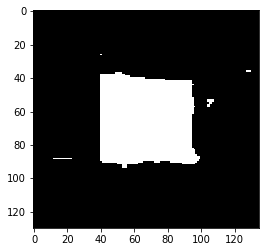

tensor([26, 36, 36,  ..., 93, 93, 93])
tensor([ 5440,  5441,  5442,  ..., 12107, 12108, 12109])


In [296]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [297]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

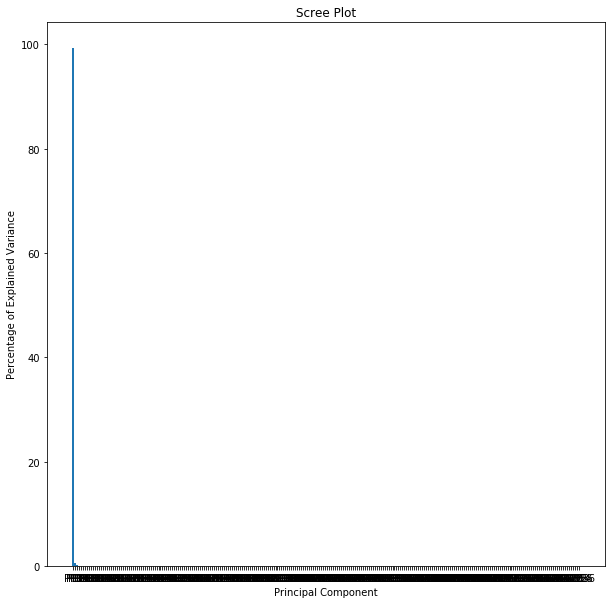

embedding46    -0.068716
embedding169   -0.068715
embedding123   -0.068715
dtype: float64


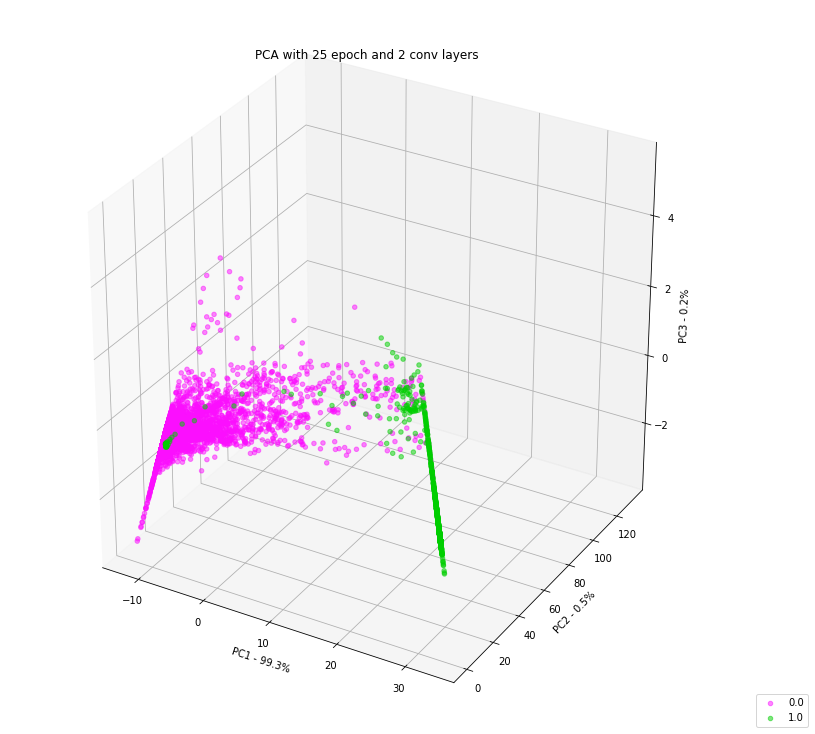

In [298]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [299]:
last_out_channel = 256
model = EmbeddingNet6(last_out_channel)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [300]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (17550, 256)
flatten_labels.shape: torch.Size([17550])
zeros count: 0
not zeros count: 17550


correct: 17332, wrong: 218, accuracy: 98.75783475783476%


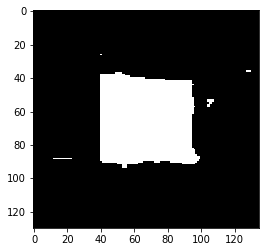

In [301]:
centroids = get_centroids(embeddings, foreground, background)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [302]:
save_centroids(centroid_path)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [303]:
last_out_channel = 256
model = EmbeddingNet6(last_out_channel)

In [304]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [305]:
heat_maps = easy_create_video(model, centroids, frames_cropped[:300], video_path, width_cropped, height_cropped, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [01:55<00:00,  1.16s/it]

Time Elapsed (get_heatmaps func) 1m 56s
Time Elapsed (create_video func) 0m 0s
Time Elapsed (easy_create_video func) 1m 56s


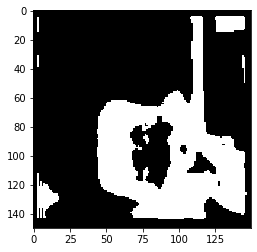

In [311]:
plt.imshow(heat_maps[2], cmap=plt.cm.gray)
plt.show()

## Experiment 4

In [338]:
model_path = 'cup_model8_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [339]:
import torch.optim as optim
import numpy as np

last_out_channel = 256
model = EmbeddingNet8(last_out_channel)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 10000.
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 25

margin: 10000.0


In [340]:
# model.load_state_dict(torch.load('Models/'+model_path+'.pt'))
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95)

Epochs:   4%|▍         | 1/25 [01:39<39:37, 99.08s/it]

loss: 9959.087891


Epochs:   8%|▊         | 2/25 [03:17<37:54, 98.87s/it]

loss: 9751.814453


Epochs:  12%|█▏        | 3/25 [04:55<36:10, 98.65s/it]

loss: 9501.879883


Epochs:  16%|█▌        | 4/25 [06:34<34:30, 98.59s/it]

loss: 9237.170898


Epochs:  20%|██        | 5/25 [08:12<32:49, 98.47s/it]

loss: 8963.083984


Epochs:  24%|██▍       | 6/25 [09:49<31:06, 98.22s/it]

loss: 8683.576172


Epochs:  28%|██▊       | 7/25 [11:27<29:26, 98.13s/it]

loss: 8403.403320


Epochs:  32%|███▏      | 8/25 [13:08<28:00, 98.85s/it]

loss: 8126.854980


Epochs:  36%|███▌      | 9/25 [14:48<26:30, 99.38s/it]

loss: 7835.379883


Epochs:  40%|████      | 10/25 [16:29<24:56, 99.76s/it]

loss: 7558.598633


Epochs:  44%|████▍     | 11/25 [18:10<23:19, 99.96s/it]

loss: 7271.984863


Epochs:  48%|████▊     | 12/25 [19:50<21:42, 100.20s/it]

loss: 6983.712402


Epochs:  52%|█████▏    | 13/25 [21:31<20:04, 100.38s/it]

loss: 6701.361816


Epochs:  56%|█████▌    | 14/25 [23:11<18:22, 100.21s/it]

loss: 6429.294434


Epochs:  60%|██████    | 15/25 [24:50<16:39, 99.98s/it] 

loss: 6144.977539


Epochs:  64%|██████▍   | 16/25 [26:30<14:59, 99.93s/it]

loss: 5857.076660


Epochs:  68%|██████▊   | 17/25 [28:08<13:14, 99.29s/it]

loss: 5571.187012


Epochs:  72%|███████▏  | 18/25 [29:47<11:34, 99.20s/it]

loss: 5284.374512


Epochs:  76%|███████▌  | 19/25 [31:25<09:53, 98.96s/it]

loss: 5000.028809


Epochs:  80%|████████  | 20/25 [33:05<08:15, 99.14s/it]

loss: 4708.654297


Epochs:  84%|████████▍ | 21/25 [34:45<06:37, 99.47s/it]

loss: 4424.669922


Epochs:  88%|████████▊ | 22/25 [36:26<04:59, 99.84s/it]

loss: 4140.958008


Epochs:  92%|█████████▏| 23/25 [38:06<03:19, 99.94s/it]

loss: 3864.242432


Epochs:  96%|█████████▌| 24/25 [39:47<01:40, 100.13s/it]

loss: 3582.653076


Epochs: 100%|██████████| 25/25 [41:27<00:00, 99.49s/it] 

loss: 3284.567627
Best val loss: 3284.567627


In [341]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (18084, 256)
flatten_labels.shape: torch.Size([18084])
zeros count: 0
not zeros count: 18084


correct: 18069, wrong: 15, accuracy: 99.91705374917053%


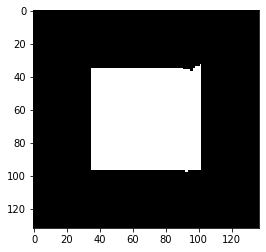

tensor([33, 34, 34,  ..., 96, 97, 97])
tensor([ 4830,  4831,  4832,  ..., 13251, 13252, 13253])


In [342]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [343]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

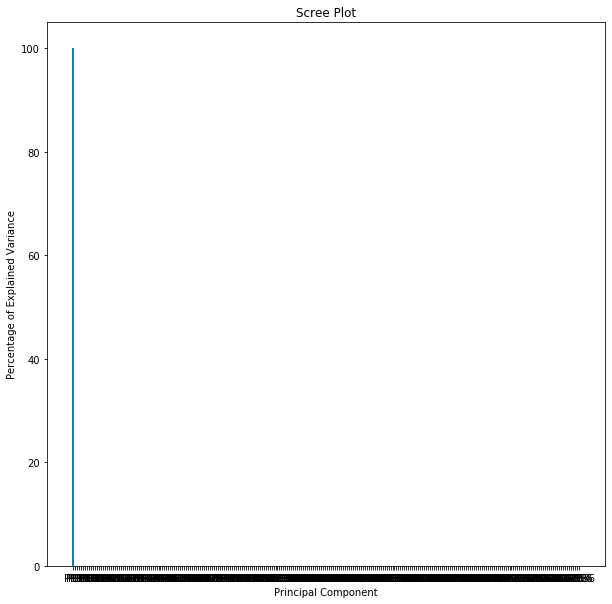

embedding35    -0.0625
embedding182   -0.0625
embedding174   -0.0625
dtype: float64


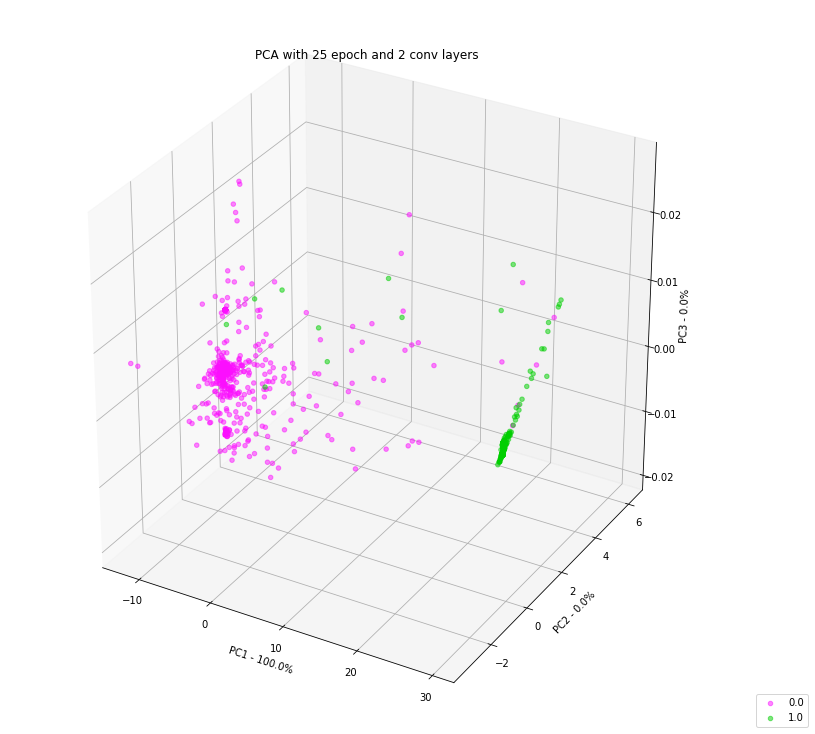

In [344]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [345]:
last_out_channel = 256
model = EmbeddingNet8(last_out_channel)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [346]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (18084, 256)
flatten_labels.shape: torch.Size([18084])
zeros count: 0
not zeros count: 18084


correct: 18069, wrong: 15, accuracy: 99.91705374917053%


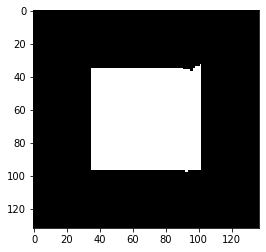

In [347]:
centroids = get_centroids(embeddings, foreground, background)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [348]:
save_centroids(centroid_path)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [351]:
last_out_channel = 256
model = EmbeddingNet8(last_out_channel)

In [352]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [353]:
heat_maps = easy_create_video(model, centroids, frames_cropped[:300], video_path, width_cropped, height_cropped, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [01:56<00:00,  1.16s/it]

Time Elapsed (get_heatmaps func) 1m 56s
Time Elapsed (create_video func) 0m 0s
Time Elapsed (easy_create_video func) 1m 56s


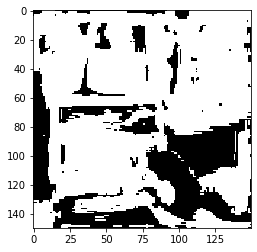

In [356]:
plt.imshow(heat_maps[50], cmap=plt.cm.gray)
plt.show()

## Experiment 5

In [429]:
model_path = 'cup_model5_1_tl'
tl_model_path = 'cup_model5_1'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [430]:
import torch.optim as optim
import numpy as np

last_out_channel = 256
model = EmbeddingNet5(last_out_channel)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 10000.
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 3

margin: 10000.0


In [431]:
model.load_state_dict(torch.load('Models/'+tl_model_path+'.pt'))
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95)

Epochs:  33%|███▎      | 1/3 [01:58<03:57, 118.83s/it]

loss: 9655.977539


Epochs:  67%|██████▋   | 2/3 [03:57<01:58, 118.84s/it]

loss: 9718.386719


Epochs: 100%|██████████| 3/3 [05:56<00:00, 118.93s/it]

loss: 6724.068359
Best val loss: 6724.068359


In [432]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (17550, 256)
flatten_labels.shape: torch.Size([17550])
zeros count: 2471
not zeros count: 15079


correct: 16811, wrong: 739, accuracy: 95.78917378917379%


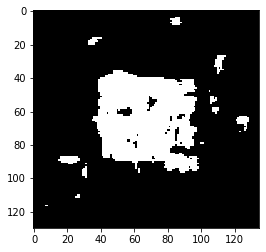

tensor([  4,   4,   4,  ..., 111, 116, 116])
tensor([ 5440,  5441,  5442,  ..., 12107, 12108, 12109])


In [433]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [434]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

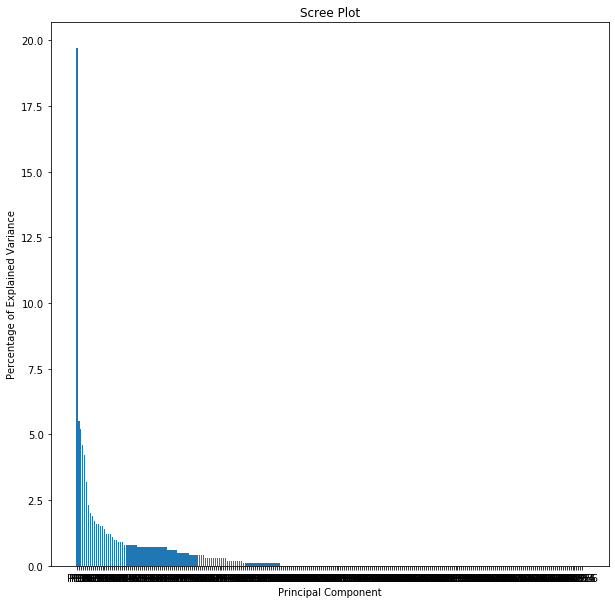

embedding100    0.193235
embedding52     0.193094
embedding174    0.193077
dtype: float64


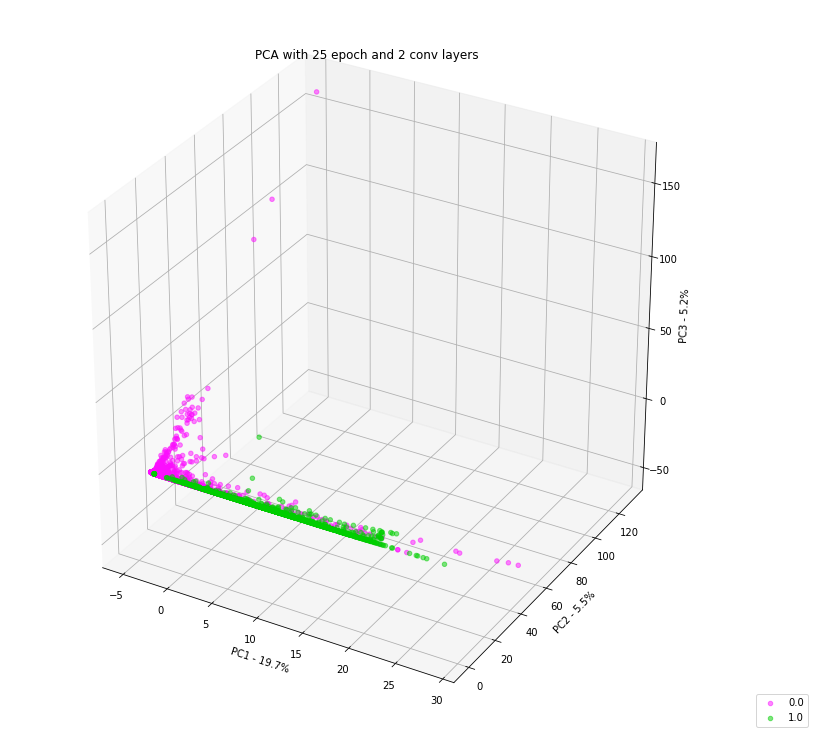

In [435]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [436]:
last_out_channel = 256
model = EmbeddingNet5(last_out_channel)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [437]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (17550, 256)
flatten_labels.shape: torch.Size([17550])
zeros count: 2471
not zeros count: 15079


correct: 16811, wrong: 739, accuracy: 95.78917378917379%


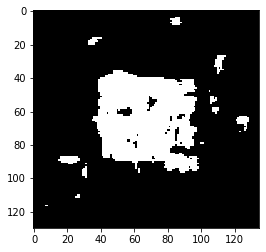

In [438]:
centroids = get_centroids(embeddings, foreground, background)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [439]:
save_centroids(centroid_path)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [440]:
last_out_channel = 256
model = EmbeddingNet5(last_out_channel)

In [441]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [442]:
heat_maps = easy_create_video(model, centroids, frames_cropped[:300], video_path, width_cropped, height_cropped, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [02:16<00:00,  1.37s/it]

Time Elapsed (get_heatmaps func) 2m 17s
Time Elapsed (create_video func) 0m 0s
Time Elapsed (easy_create_video func) 2m 17s


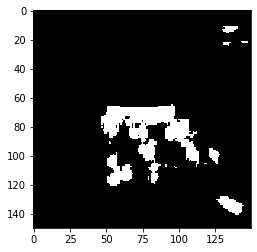

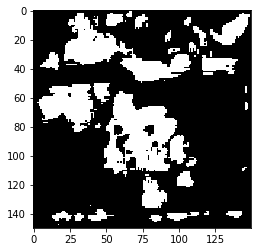

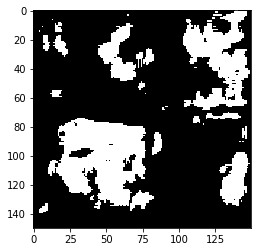

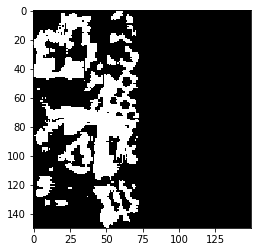

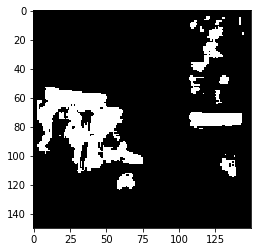

In [443]:
plt.imshow(heat_maps[0], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[25], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[50], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[75], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[-1], cmap=plt.cm.gray)
plt.show()

## Load another image

(240, 320)


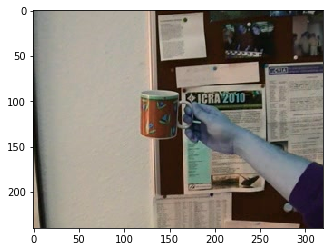

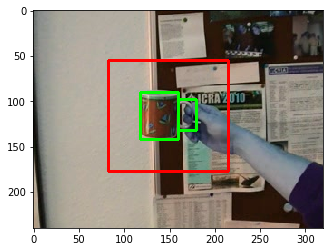

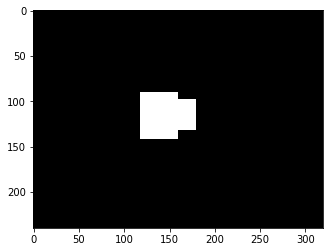

In [57]:
img_path = tar_path+cup_video_path+'/img0043.jpg'

#Import image
orig_image = cv2.imread(img_path)
#Show the image with matplotlib
start_point = (118, 90)   
end_point = (160, 142)
start_point2 = (160,98)   
end_point2 = (180, 132)
padding = 35
start_point_pad = (start_point[0]-padding, start_point[1]-padding)
end_point_pad = (end_point2[0]+padding, end_point[1]+padding)
# Blue color in BGR 
color = (0, 255, 0) 
color_pad = (255, 0, 0)
# Line thickness of 2 px 
thickness = 2
image = orig_image.copy()
image = cv2.rectangle(image, start_point, end_point, color, thickness) 
image = cv2.rectangle(image, start_point2, end_point2, color, thickness) 
image = cv2.rectangle(image, start_point_pad, end_point_pad, color_pad, thickness) 


# label image
image_labels = np.zeros((orig_image.shape[0], orig_image.shape[1]))
image_labels[start_point[1]:end_point[1], start_point[0]:end_point[0]] = 1.0
image_labels[start_point2[1]:end_point2[1], start_point2[0]:end_point2[0]] = 1.0
print(image_labels.shape)
#Show the image with matplotlib
plt.imshow(orig_image)
plt.show()
plt.imshow(image)
plt.show()
plt.imshow(image_labels, cmap=plt.cm.gray)
plt.show()

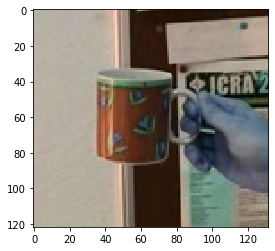

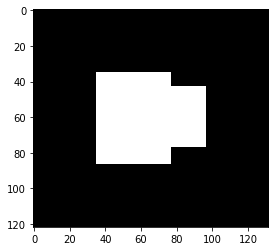

torch.Size([122, 132])
torch.Size([1, 3, 122, 132])
torch.Size([16104])


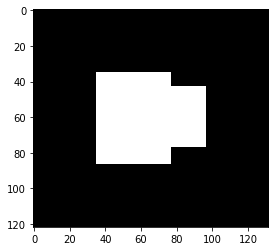

tensor([ 4655,  4656,  4657,  ..., 11426, 11427, 11428])
tensor([    0,     1,     2,  ..., 16101, 16102, 16103])


In [58]:
import torch

img = orig_image[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(img)
plt.show()

labels = image_labels[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(labels, cmap=plt.cm.gray)
plt.show()

img = np.moveaxis(img, -1, 0)
img = torch.tensor(img)
img = img.float()
img = img.unsqueeze(0)
labels = torch.tensor(labels)

print(labels.shape)
print(img.shape)
flatten_labels = labels.view(-1)
print(flatten_labels.shape)

test_flatten_labels = flatten_labels.reshape((labels.shape[0], labels.shape[1]))

plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

foreground = torch.where(flatten_labels == 1)[0]
background = torch.where(flatten_labels == 0)[0]
print(foreground)
print(background)

## Experiment 5

In [550]:
model_path = 'cup_model9_1_2'
centroid_path = 'Centroids/' + model_path + '_centroids_2' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'_2.avi'

In [491]:
import torch.optim as optim
import numpy as np

last_out_channel = 64
model = EmbeddingNet9(last_out_channel)

margin: 0.2


In [542]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 0.4
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 2

margin: 0.4


In [543]:
# model.load_state_dict(torch.load('Models/'+model_path+'.pt'))
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95, get_min_loss=False)

Epochs:  50%|█████     | 1/2 [01:15<01:15, 75.50s/it]

loss: 0.005639


Epochs: 100%|██████████| 2/2 [02:31<00:00, 75.83s/it]

loss: 0.004065
Best val loss: 0.004065


In [544]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (16104, 64)
flatten_labels.shape: torch.Size([16104])
zeros count: 2135
not zeros count: 13969


correct: 16084, wrong: 20, accuracy: 99.87580725285643%


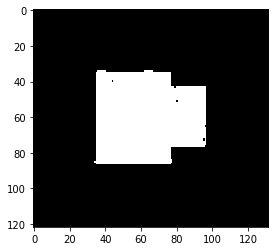

tensor([34, 34, 34,  ..., 86, 86, 86])
tensor([ 4655,  4656,  4657,  ..., 11426, 11427, 11428])


In [545]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [547]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

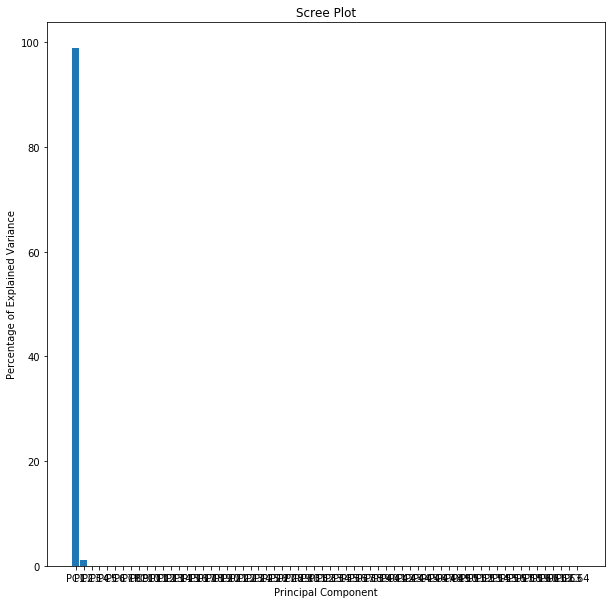

embedding45   -7.071068e-01
embedding22   -7.071068e-01
embedding2     1.110223e-16
dtype: float64


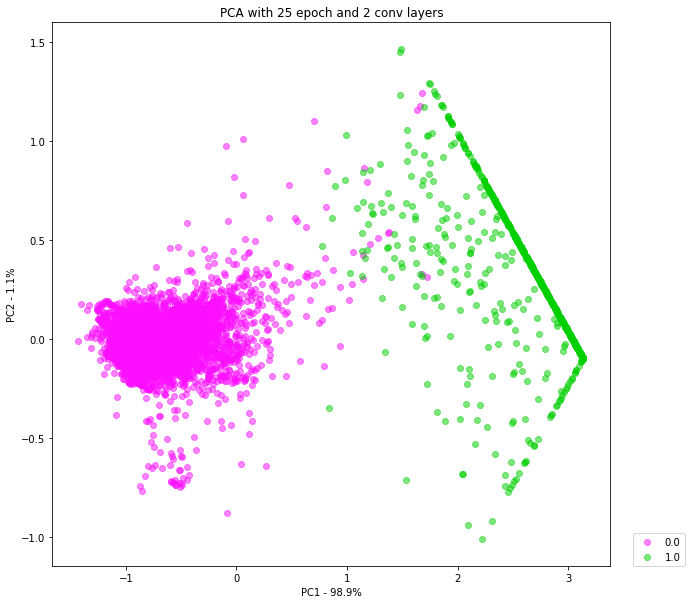

In [548]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=False, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [551]:
last_out_channel = 64
model = EmbeddingNet9(last_out_channel)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (16104, 64)
flatten_labels.shape: torch.Size([16104])
zeros count: 2135
not zeros count: 13969


correct: 16084, wrong: 20, accuracy: 99.87580725285643%


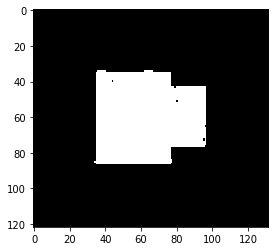

In [552]:
centroids = get_centroids(embeddings, foreground, background)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [553]:
save_centroids(centroid_path)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [554]:
last_out_channel = 64
model = EmbeddingNet9(last_out_channel)

In [555]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [556]:
heat_maps = easy_create_video(model, centroids, frames_cropped[:300], video_path, width_cropped, height_cropped, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]

Time Elapsed (get_heatmaps func) 1m 23s
Time Elapsed (create_video func) 0m 0s
Time Elapsed (easy_create_video func) 1m 23s


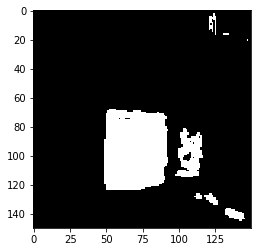

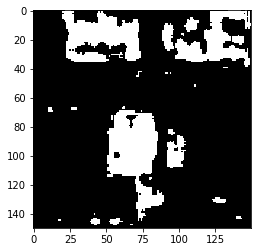

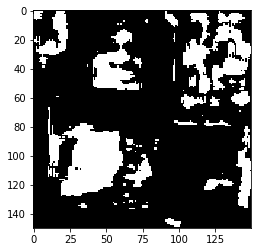

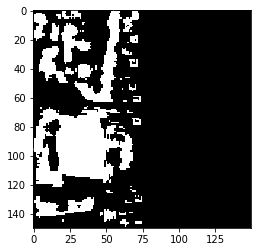

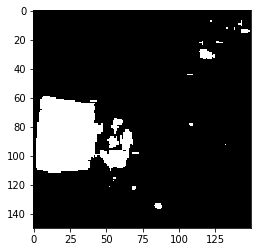

In [557]:
plt.imshow(heat_maps[0], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[25], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[50], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[75], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[-1], cmap=plt.cm.gray)
plt.show()

## Load another image

(240, 320)


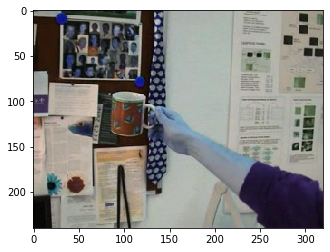

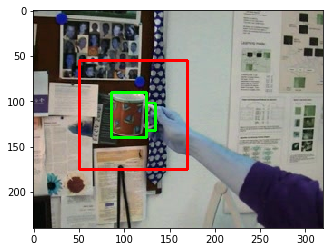

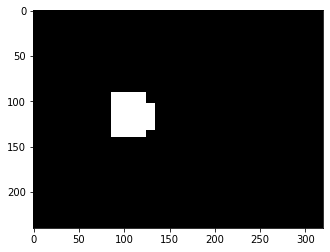

In [59]:
img_path = tar_path+cup_video_path+'/img0225.jpg'

#Import image
orig_image = cv2.imread(img_path)
#Show the image with matplotlib
start_point = (86, 90)   
end_point = (125, 140)
start_point2 = (125,102)   
end_point2 = (135, 132)
padding = 35
start_point_pad = (start_point[0]-padding, start_point[1]-padding)
end_point_pad = (end_point2[0]+padding, end_point[1]+padding)
# Blue color in BGR 
color = (0, 255, 0) 
color_pad = (255, 0, 0)
# Line thickness of 2 px 
thickness = 2
image = orig_image.copy()
image = cv2.rectangle(image, start_point, end_point, color, thickness) 
image = cv2.rectangle(image, start_point2, end_point2, color, thickness) 
image = cv2.rectangle(image, start_point_pad, end_point_pad, color_pad, thickness) 


# label image
image_labels = np.zeros((orig_image.shape[0], orig_image.shape[1]))
image_labels[start_point[1]:end_point[1], start_point[0]:end_point[0]] = 1.0
image_labels[start_point2[1]:end_point2[1], start_point2[0]:end_point2[0]] = 1.0
print(image_labels.shape)
#Show the image with matplotlib
plt.imshow(orig_image)
plt.show()
plt.imshow(image)
plt.show()
plt.imshow(image_labels, cmap=plt.cm.gray)
plt.show()

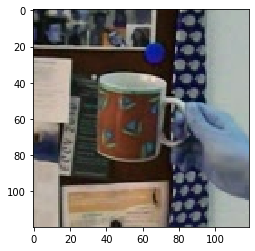

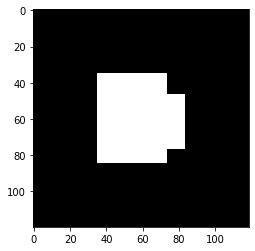

torch.Size([120, 119])
torch.Size([1, 3, 120, 119])
torch.Size([14280])


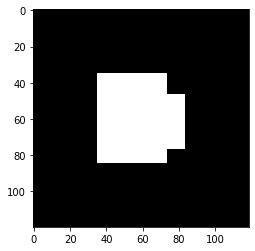

tensor([ 4200,  4201,  4202,  ..., 10067, 10068, 10069])
tensor([    0,     1,     2,  ..., 14277, 14278, 14279])


In [60]:
import torch

img = orig_image[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(img)
plt.show()

labels = image_labels[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(labels, cmap=plt.cm.gray)
plt.show()

img = np.moveaxis(img, -1, 0)
img = torch.tensor(img)
img = img.float()
img = img.unsqueeze(0)
labels = torch.tensor(labels)

print(labels.shape)
print(img.shape)
flatten_labels = labels.view(-1)
print(flatten_labels.shape)

test_flatten_labels = flatten_labels.reshape((labels.shape[0], labels.shape[1]))

plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

foreground = torch.where(flatten_labels == 1)[0]
background = torch.where(flatten_labels == 0)[0]
print(foreground)
print(background)

## Experiment 5.2

In [593]:
model_path = 'cup_model9_1_4'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [574]:
import torch.optim as optim
import numpy as np

last_out_channel = 64
model = EmbeddingNet9(last_out_channel)

In [589]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 0.4
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 3

margin: 0.4


In [ ]:
model.load_state_dict(torch.load('Models/'+'cup_model9_1_2'+'.pt'))

In [590]:
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95, get_min_loss=False)

Epochs:  33%|███▎      | 1/3 [01:17<02:34, 77.26s/it]

loss: 0.012874


Epochs:  67%|██████▋   | 2/3 [02:34<01:17, 77.32s/it]

loss: 0.008553


Epochs: 100%|██████████| 3/3 [03:52<00:00, 77.41s/it]

loss: 0.007763
Best val loss: 0.007763


In [591]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (14280, 64)
flatten_labels.shape: torch.Size([14280])
zeros count: 2009
not zeros count: 12271


correct: 14254, wrong: 26, accuracy: 99.81792717086834%


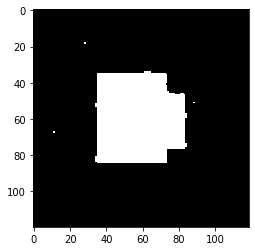

tensor([18, 34, 34,  ..., 84, 84, 84])
tensor([ 4200,  4201,  4202,  ..., 10067, 10068, 10069])


In [592]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [594]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

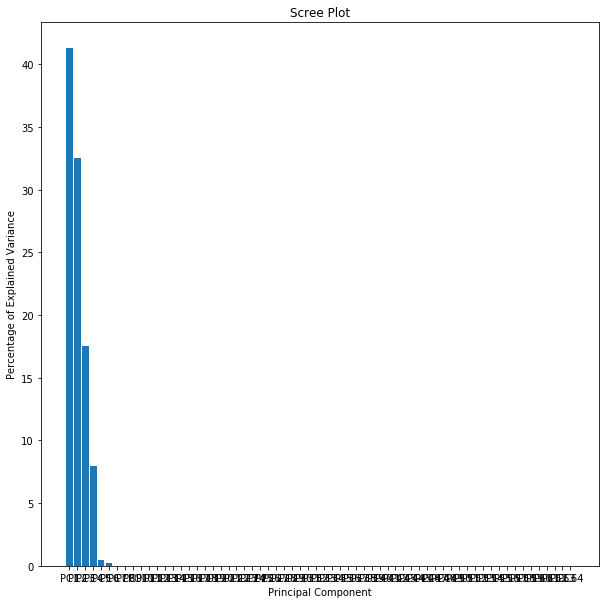

embedding10    0.601625
embedding5     0.546952
embedding34    0.401419
dtype: float64


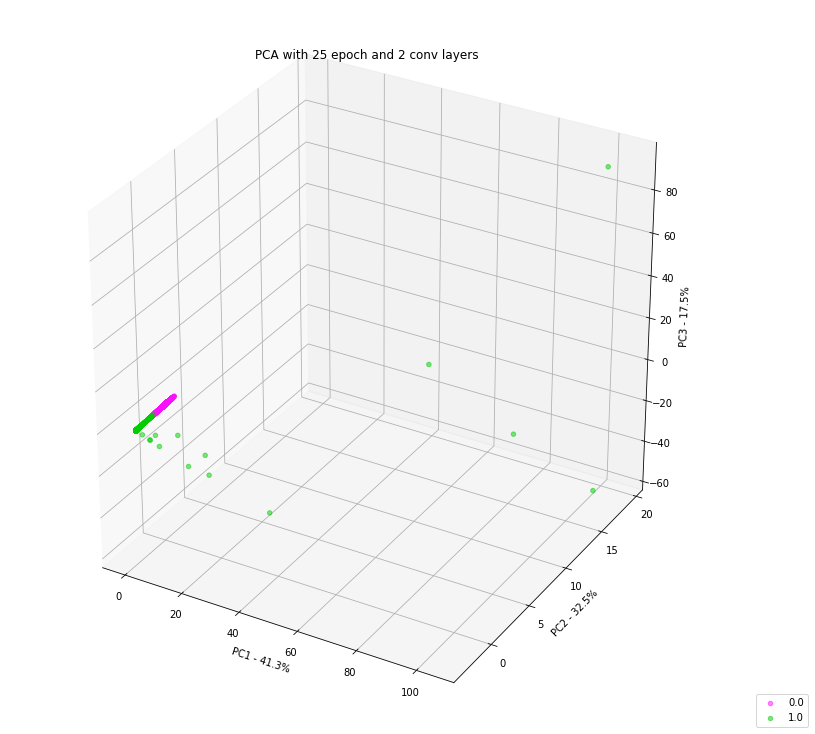

In [603]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [596]:
last_out_channel = 64
model = EmbeddingNet9(last_out_channel)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [597]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (14280, 64)
flatten_labels.shape: torch.Size([14280])
zeros count: 2009
not zeros count: 12271


correct: 14254, wrong: 26, accuracy: 99.81792717086834%


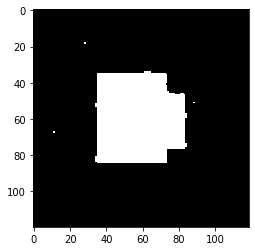

In [598]:
centroids = get_centroids(embeddings, foreground, background)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [599]:
save_centroids(centroid_path)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [600]:
last_out_channel = 64
model = EmbeddingNet9(last_out_channel)

centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [601]:
heat_maps = easy_create_video(model, centroids, frames_cropped[:300], video_path, width_cropped, height_cropped, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False)

Generate Heat Maps: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]

Time Elapsed (get_heatmaps func) 1m 22s
Time Elapsed (create_video func) 0m 0s
Time Elapsed (easy_create_video func) 1m 22s


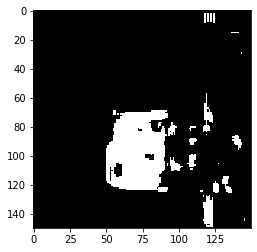

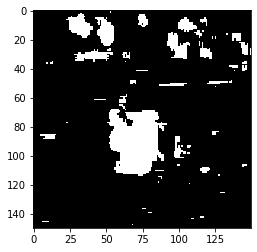

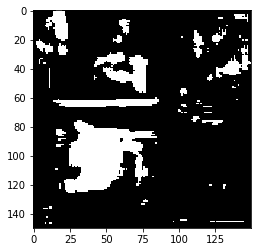

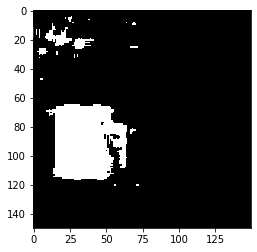

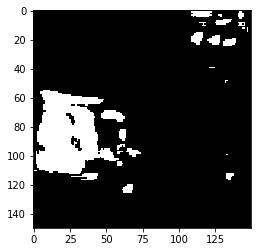

In [602]:
plt.imshow(heat_maps[0], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[25], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[50], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[75], cmap=plt.cm.gray)
plt.show()
plt.imshow(heat_maps[-1], cmap=plt.cm.gray)
plt.show()

## Load another image

(240, 320)


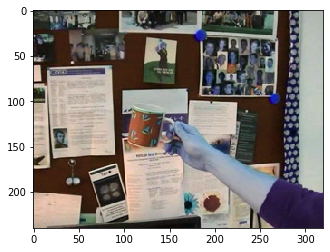

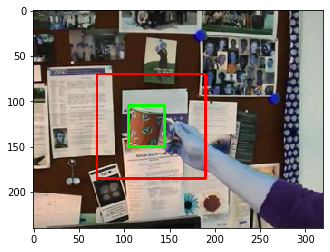

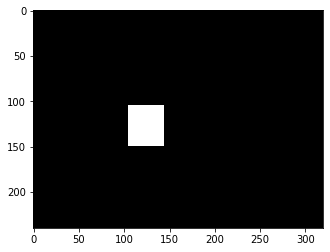

In [135]:
img_path = tar_path+cup_video_path+'/img0150.jpg'

#Import image
orig_image = cv2.imread(img_path)
#Show the image with matplotlib
start_point = (105, 105)   
end_point = (145, 150)
start_point2 = (145,120)   
end_point2 = (155, 143)
padding = 35
start_point_pad = (start_point[0]-padding, start_point[1]-padding)
end_point_pad = (end_point2[0]+padding, end_point[1]+padding)
# Blue color in BGR 
color = (0, 255, 0) 
color_pad = (255, 0, 0)
# Line thickness of 2 px 
thickness = 2
image = orig_image.copy()
image = cv2.rectangle(image, start_point, end_point, color, thickness) 
# image = cv2.rectangle(image, start_point2, end_point2, color, thickness) 
image = cv2.rectangle(image, start_point_pad, end_point_pad, color_pad, thickness) 


# label image
image_labels = np.zeros((orig_image.shape[0], orig_image.shape[1]))
image_labels[start_point[1]:end_point[1], start_point[0]:end_point[0]] = 1.0
# image_labels[start_point2[1]:end_point2[1], start_point2[0]:end_point2[0]] = 1.0
print(image_labels.shape)
#Show the image with matplotlib
plt.imshow(orig_image)
plt.show()
plt.imshow(image)
plt.show()
plt.imshow(image_labels, cmap=plt.cm.gray)
plt.show()

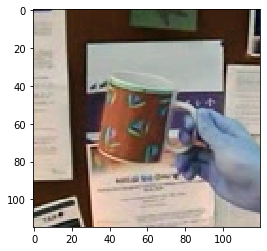

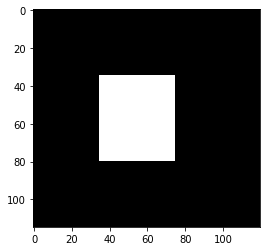

torch.Size([115, 120])
torch.Size([1, 3, 115, 120])
torch.Size([13800])


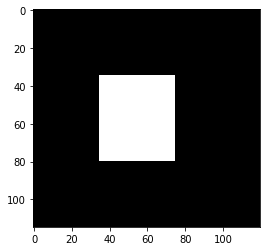

tensor([4235, 4236, 4237,  ..., 9552, 9553, 9554])
tensor([    0,     1,     2,  ..., 13797, 13798, 13799])


In [136]:
import torch

img = orig_image[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(img)
plt.show()

labels = image_labels[start_point_pad[1]:end_point_pad[1], start_point_pad[0]:end_point_pad[0]]
plt.imshow(labels, cmap=plt.cm.gray)
plt.show()

img = np.moveaxis(img, -1, 0)
img = torch.tensor(img)
img = img.float()
img = img.unsqueeze(0)
labels = torch.tensor(labels)

print(labels.shape)
print(img.shape)
flatten_labels = labels.view(-1)
print(flatten_labels.shape)

test_flatten_labels = flatten_labels.reshape((labels.shape[0], labels.shape[1]))

plt.imshow(test_flatten_labels, cmap=plt.cm.gray)
plt.show()

foreground = torch.where(flatten_labels == 1)[0]
background = torch.where(flatten_labels == 0)[0]
print(foreground)
print(background)

## Experiment 5.3

In [61]:
model_path = 'cup_model9_1_5'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [62]:
import torch.optim as optim
import numpy as np

last_out_channel = 64
model = EmbeddingNet9(last_out_channel)

In [63]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = 0.4
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 3

margin: 0.4


In [64]:
model.load_state_dict(torch.load('Models/'+'cup_model9_1_4'+'.pt'))

<All keys matched successfully>

In [65]:
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95, get_min_loss=False)

Epochs:  33%|███▎      | 1/3 [01:17<02:35, 77.77s/it]

loss: 0.006002


Epochs:  67%|██████▋   | 2/3 [02:35<01:17, 77.74s/it]

loss: 0.005707


Epochs: 100%|██████████| 3/3 [03:53<00:00, 77.74s/it]

loss: 0.005589
Best val loss: 0.005589


In [66]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (14280, 64)
flatten_labels.shape: torch.Size([14280])
zeros count: 2119
not zeros count: 12161


correct: 14195, wrong: 85, accuracy: 99.4047619047619%


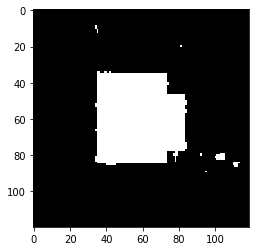

tensor([ 9, 10, 11,  ..., 86, 86, 89])
tensor([ 4200,  4201,  4202,  ..., 10067, 10068, 10069])


In [67]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [68]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

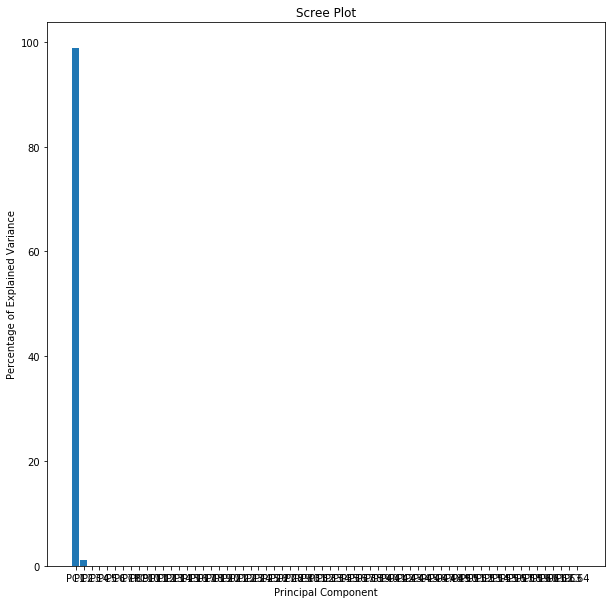

embedding22   -7.071068e-01
embedding45   -7.071068e-01
embedding2     6.661338e-16
dtype: float64


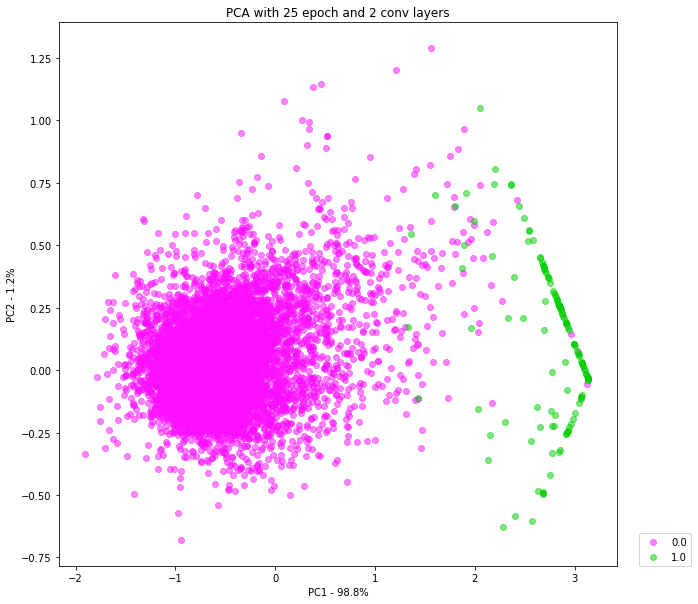

In [69]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=False, pca_title='PCA with 25 epoch and 2 conv layers', draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [70]:
last_out_channel = 64
model = EmbeddingNet9(last_out_channel)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [71]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (14280, 64)
flatten_labels.shape: torch.Size([14280])
zeros count: 2119
not zeros count: 12161


correct: 14195, wrong: 85, accuracy: 99.4047619047619%


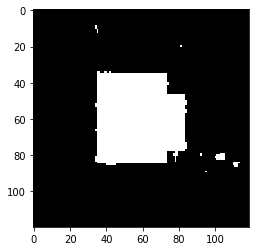

In [72]:
centroids = get_centroids(embeddings, foreground, background)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels.shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [73]:
save_centroids(centroid_path)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [156]:
last_out_channel = 64
model = EmbeddingNet9(last_out_channel)

In [157]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [158]:
video_path = 'Videos/10fps_cropped_real_'+model_path+'.avi'
heat_maps = get_real_heatmaps(model, centroids, frames_cropped[:300], (height_cropped, width_cropped), frames_step=3, num_classes=2, use_gpu=True)
# heat_maps = easy_create_video(model, centroids, frames_cropped[:300], video_path, width_cropped, height_cropped, frames_step=3, fps=10, ret_heat_maps=True, use_gpu=False, real_heat_map=True)

Generate Heat Maps: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]

Time Elapsed (get_heatmaps func) 1m 12s


In [184]:
heatmap_path = 'heatmaps/heatmap'
for idx, heat_map in enumerate(heat_maps):
    sns.heatmap(heat_map, cmap = 'jet', vmin=0, vmax=160)
    plt.savefig(heatmap_path + str(idx) + '.jpg', dpi=200)
    plt.clf() # clear figure (v.imp)    

<Figure size 432x288 with 0 Axes>

In [179]:
video = cv2.VideoWriter(video_path, 0, 10, (width, height))
for idx in range(len(heat_maps)):
    video.write(cv2.imread(heatmap_path + str(idx) + '.jpg'))
video.release()

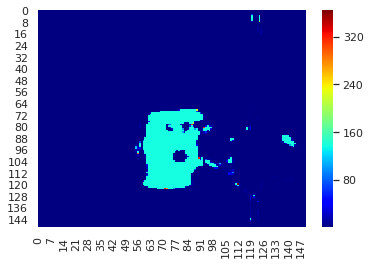

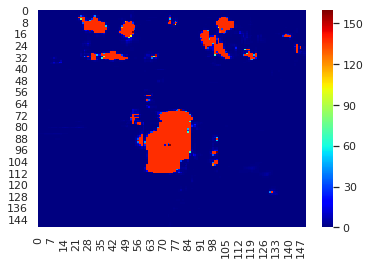

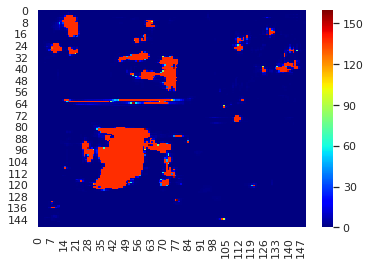

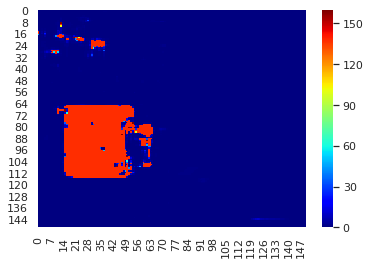

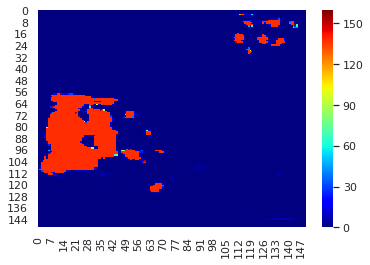

In [185]:
# print((width, height))
heat_map = sns.heatmap(heat_maps[0], cmap = 'jet')
plt.show()
heat_map = sns.heatmap(heat_maps[25], cmap = 'jet', vmin=0, vmax=160) 
plt.show()
heat_map = sns.heatmap(heat_maps[50], cmap = 'jet', vmin=0, vmax=160) 
plt.show()
heat_map = sns.heatmap(heat_maps[75], cmap = 'jet', vmin=0, vmax=160) 
plt.show()
heat_map = sns.heatmap(heat_maps[-1], cmap = 'jet', vmin=0, vmax=160) 
plt.show()

### Create Video

In [3]:
from networks import *
from functions import *
from imageloader import *

#### Load Cropped Frames

In [5]:
tar_path = 'data/'
cup_video_path = 'Vid_B_cup'
image_folder = tar_path + cup_video_path
frames_cropped, height_cropped, width_cropped = get_cropped_frames(image_folder)

In [6]:
model_path = 'cup_model9_1_5'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_real_'+model_path+'.avi'

In [7]:
last_out_channel = 64
model = EmbeddingNet9(last_out_channel)

In [8]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [9]:
frames_step = 3

real_heat_maps = easy_create_real_video(model, centroids, frames_cropped, video_path, width_cropped,
                                        height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg')

Generate Heat Maps: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Time Elapsed (get_heatmaps func) 1m 10s


<Figure size 432x288 with 0 Axes>

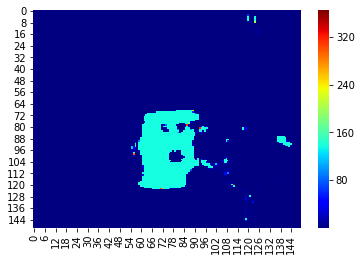

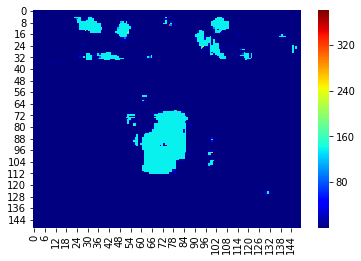

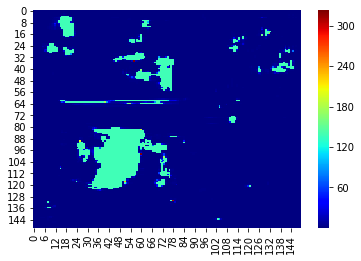

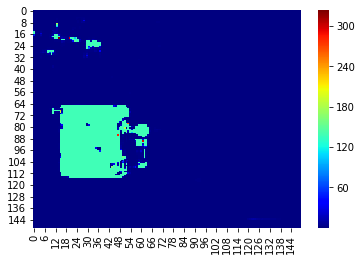

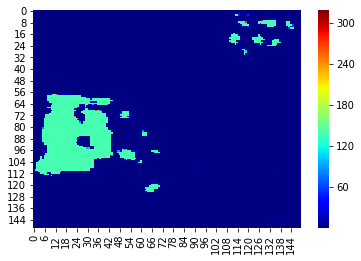

In [10]:
heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet')
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet') 
plt.show()